In [1]:
import numpy as np
import pandas as pd

path = r"C:\Users\HP\OneDrive\Escritorio\David Guzzi\DiTella\MEC\Materias\2025\2025 1T\[MT10] Series de Tiempo\Clases prácticas\Prácticas\Práctica 4-20250516\rp.txt"
df = pd.read_csv(path, delimiter="\t", decimal=".")
df.drop(columns=["Name"], inplace=True)
df.head()

,dateid01,dateid,r3,r6,tb3ms,tb6ms,y
0,NaN,NaN,NaN,NaN,TB3MS,NaN,NaN
1,TB6MS,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1934-01-01,1934-03-31 23:59:59.999,NaN,NaN,0.52666666666666664,NaN,NaN
4,1934-04-01,1934-06-30 23:59:59.999,NaN,NaN,0.15333333333333332,NaN,NaN


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   dateid01  346 non-null    object 
 1   dateid    345 non-null    object 
 2   r3        98 non-null     float64
 3   r6        98 non-null     float64
 4   tb3ms     346 non-null    object 
 5   tb6ms     246 non-null    float64
 6   y         97 non-null     float64
dtypes: float64(4), object(3)
memory usage: 19.2+ KB


In [2]:
df_clean = df.dropna().reset_index(drop=True)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   dateid01  97 non-null     object 
 1   dateid    97 non-null     object 
 2   r3        97 non-null     float64
 3   r6        97 non-null     float64
 4   tb3ms     97 non-null     object 
 5   tb6ms     97 non-null     float64
 6   y         97 non-null     float64
dtypes: float64(4), object(3)
memory usage: 5.4+ KB


In [51]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import norm, chi2
from statsmodels.tsa.stattools import acf, pacf
from matplotlib import pyplot as plt

class ARCHModelEViewsStyle:
    def __init__(self, y, p=4, backcast_lambda=0.7):
        self.y = np.asarray(y, float)
        self.n = len(y)
        self.p = p
        self.lam = backcast_lambda
        self.k = 1 + 1 + p

    def _compute_sigma2(self, θ):
        μ, logω, *logα = θ
        ω = np.exp(logω)
        α = np.exp(logα)
        e = self.y - μ
        σ2 = np.empty(self.n)
        w = (1 - self.lam)*self.lam**np.arange(self.p)
        bc = (w @ (e[:self.p][::-1]**2)) / w.sum()
        for t in range(self.n):
            σ2[t] = bc if t < self.p else ω + (α * e[t-self.p:t][::-1]**2).sum()
        return σ2, e

    def loglike(self, θ):
        σ2, e = self._compute_sigma2(θ)
        return -0.5 * np.sum(np.log(2*np.pi) + np.log(σ2) + e**2/σ2)

    def fit(self, maxiter=500, tol=1e-4):
        μ0 = self.y.mean()
        logω0 = np.log(0.1*self.y.var())
        logα0 = np.log(np.full(self.p, 0.1))
        x0 = np.r_[μ0, logω0, logα0]

        res = minimize(lambda th: -self.loglike(th), x0,
                       method="BFGS",
                       options={"maxiter": maxiter, "gtol": tol, "disp": False})
        self.params = res.x
        self.llf = -res.fun
        self.nit = res.nit

        σ2, e = self._compute_sigma2(self.params)
        self.cond_vol2 = σ2
        self.resid = e
        SSR = (e**2).sum()
        σ̂ = np.sqrt(SSR/self.n)

        # ==== OPG ====
        # calcular score sólo de t=p..n-1
        score = np.zeros((self.n - self.p, self.k))
        μ, logω, *logα = self.params
        ω = np.exp(logω)
        α = np.exp(logα)
        for idx, t in enumerate(range(self.p, self.n)):
            st = (e[t]**2/σ2[t] - 1)/(2*σ2[t])
            score[idx, 0] = e[t]/σ2[t]
            score[idx, 1] = st*ω
            for j in range(self.p):
                score[idx, 2+j] = st*α[j]*(e[t-j-1]**2)

        M = score.T @ score
        df = self.n - self.p
        cov_log = np.linalg.inv(M/df)/df

        # transformamos parámetros y errors al nivel
        coef = np.r_[μ, ω, α]
        se_log = np.sqrt(np.diag(cov_log))
        se = np.empty(self.k)
        se[0] = se_log[0]
        se[1] = se_log[1]*ω
        for j in range(self.p):
            se[2+j] = se_log[2+j]*α[j]

        z = coef/se
        pval = 2*(1 - norm.cdf(np.abs(z)))

        # métricas
        R2 = 1 - SSR/((self.y - self.y.mean())**2).sum()
        aic = -2*self.llf/self.n + 2*self.k/self.n
        bic = -2*self.llf/self.n + np.log(self.n)*self.k/self.n
        hqc = -2*self.llf/self.n + 2*np.log(np.log(self.n))*self.k/self.n
        dw = durbin_watson(e)

        self.summary = dict(
            coef=coef, se=se, z=z, p=pval,
            llf=self.llf, aic=aic, bic=bic, hqc=hqc,
            R2=R2, SSR=SSR, sigma_hat=σ̂, dw=dw
        )
        return self

    def print_summary(self):
        s = self.summary
        print("Dependent Variable: Y")
        print("Method: ML ARCH - Normal distribution (BFGS / Marquardt steps)")
        print("Sample (adjusted): 1960Q1 1984Q1")
        print(f"Included observations: {self.n} after adjustments")
        print(f"Convergence achieved after {self.nit} iterations")
        print("Coefficient covariance computed using outer product of gradients")
        print(f"Presample variance: backcast (parameter = {self.lam})")
        eq = "GARCH = C(2)"
        for i in range(self.p):
            eq += f" + C({3+i})*RESID(-{i+1})^2"
        print(eq + "\n")

        print("Variable\tCoefficient\tStd. Error\tz-Statistic\tProb.")
        # Primero la media
        print(f"C\t{s['coef'][0]:.6f}\t{s['se'][0]:.6f}\t{s['z'][0]:.6f}\t{s['p'][0]:.4f}\n")
        print("\tVariance Equation")
        print(f"C\t{s['coef'][1]:.6f}\t{s['se'][1]:.6f}\t{s['z'][1]:.6f}\t{s['p'][1]:.4f}")
        for j in range(self.p):
            lab = f"RESID(-{j+1})^2"
            i = 2+j
            print(f"{lab}\t{s['coef'][i]:.6f}\t{s['se'][i]:.6f}\t{s['z'][i]:.6f}\t{s['p'][i]:.4f}")

        print(f"\nR-squared\t{s['R2']:.6f}\tMean dependent var\t{self.y.mean():.6f}")
        print(f"Adjusted R-squared\t{s['R2']:.6f}\tS.D. dependent var\t{self.y.std():.6f}")
        print(f"S.E. of regression\t{s['sigma_hat']:.6f}\tAkaike info criterion\t{s['aic']:.6f}")
        print(f"Sum squared resid\t{s['SSR']:.6f}\tSchwarz criterion\t{s['bic']:.6f}")
        print(f"Log likelihood\t{s['llf']:.6f}\tHannan-Quinn criter.\t{s['hqc']:.6f}")
        print(f"Durbin-Watson stat\t{s['dw']:.6f}")
    
    def resid_correlogram(self, nlags=36, alpha=0.05):
        """
        Correlograma de los residuos estandarizados al cuadrado,
        replicando exactamente el View > Residual Diagnostics >
        Correlogram Squared Residuals de EViews.
        """
        # 1) Saca la volatilidad condicional estimada sigma_t^2
        #    Si en tu fit() guardas self.cond_vol2, úsalo.
        #    Aquí asumo que lo guardaste en self.cond_vol2:
        sigma2 = self.cond_vol2  
        # 2) Calcula residuos estandarizados
        z = self.resid / np.sqrt(sigma2)
        # 3) Squared standardized residuals
        x = z**2
        n = len(x)

        # ACF omitiendo lag 0
        ac = acf(x, nlags=nlags, fft=False)[1:]
        # PACF por Yule-Walker
        pac = pacf(x, nlags=nlags, method='yw')[1:]

        # Q-Stat con la fórmula de EViews
        Q = np.zeros(nlags)
        pvals = np.zeros(nlags)
        for m in range(1, nlags+1):
            s = np.sum([ac[i-1]**2/(n - i) for i in range(1, m+1)])
            Qm = n*(n+2)*s
            Q[m-1] = Qm
            pvals[m-1] = 1 - chi2.cdf(Qm, df=m)

        # Imprime al estilo EViews
        print(f"Sample: 1960Q1 1984Q2   Included observations: {n}\n")
        print("Lag\t   AC      PAC     Q-Stat    Prob*")
        crit = norm.ppf(1 - alpha/2)/np.sqrt(n)
        for i in range(nlags):
            star_ac  = "*" if abs(ac[i])  > crit else " "
            star_pac = "*" if abs(pac[i]) > crit else " "
            print(f"{i+1:>3}\t{ac[i]:>7.3f}{star_ac}\t"
                  f"{pac[i]:>7.3f}{star_pac}\t"
                  f"{Q[i]:>7.4f}\t{pvals[i]:>6.3f}")
        print("\n*Probabilities may not be valid for this equation specification.")

    def plot_conditional_variance(self, dates=None):
        """
        Grafica la varianza condicional estimada (sigma^2) al estilo
        GARCH graphs > Conditional variance de EViews.
        Si se proporciona 'dates', las usa como eje x; si no, usa índices.
        """
        sigma2 = self.cond_vol2
        n = len(sigma2)

        # Preparar eje x
        if dates is not None:
            x = dates
        else:
            x = np.arange(n)

        plt.figure()  # gráfico independiente
        plt.plot(x, sigma2)
        plt.title("Conditional Variance")
        plt.xlabel("Time")
        plt.ylabel("σ²")
        plt.grid(True)
        plt.show()

In [52]:
y = df_clean['y'].astype(float)
model = ARCHModelEViewsStyle(y, p=4, backcast_lambda=0.7)
res = model.fit()
res.print_summary()

Dependent Variable: Y
Method: ML ARCH - Normal distribution (BFGS / Marquardt steps)
Sample (adjusted): 1960Q1 1984Q1
Included observations: 97 after adjustments
Convergence achieved after 39 iterations
Coefficient covariance computed using outer product of gradients
Presample variance: backcast (parameter = 0.7)
GARCH = C(2) + C(3)*RESID(-1)^2 + C(4)*RESID(-2)^2 + C(5)*RESID(-3)^2 + C(6)*RESID(-4)^2

Variable	Coefficient	Std. Error	z-Statistic	Prob.
C	0.054305	0.012602	4.309221	0.0000

	Variance Equation
C	0.002777	0.001923	1.444053	0.1487
RESID(-1)^2	0.628140	0.194594	3.227960	0.0012
RESID(-2)^2	0.000000	0.126337	0.000000	1.0000
RESID(-3)^2	0.095199	0.140289	0.678594	0.4974
RESID(-4)^2	0.711920	0.233344	3.050949	0.0023

R-squared	-0.005836	Mean dependent var	0.073290
Adjusted R-squared	-0.005836	S.D. dependent var	0.248519
S.E. of regression	0.249243	Akaike info criterion	-0.524712
Sum squared resid	6.025847	Schwarz criterion	-0.365452
Log likelihood	31.448549	Hannan-Quinn criter.	-0

In [49]:
res.resid_correlogram(nlags=36)

Sample: 1960Q1 1984Q2   Included observations: 97

Lag	   AC      PAC     Q-Stat    Prob*
  1	 -0.000 	 -0.000 	 0.0000	 0.999
  2	  0.060 	  0.061 	 0.3661	 0.833
  3	 -0.010 	 -0.010 	 0.3761	 0.945
  4	  0.083 	  0.083 	 1.0920	 0.896
  5	  0.026 	  0.029 	 1.1637	 0.948
  6	  0.028 	  0.020 	 1.2444	 0.975
  7	 -0.133 	 -0.147 	 3.1349	 0.872
  8	 -0.040 	 -0.055 	 3.3080	 0.914
  9	 -0.095 	 -0.096 	 4.2838	 0.892
 10	 -0.013 	 -0.018 	 4.3037	 0.933
 11	  0.062 	  0.108 	 4.7398	 0.943
 12	 -0.073 	 -0.066 	 5.3491	 0.945
 13	 -0.147 	 -0.161 	 7.8088	 0.856
 14	 -0.108 	 -0.141 	 9.1522	 0.821
 15	  0.066 	  0.075 	 9.6607	 0.841
 16	  0.181 	  0.243*	13.5573	 0.632
 17	 -0.096 	 -0.110 	14.6679	 0.619
 18	 -0.069 	 -0.101 	15.2424	 0.645
 19	  0.015 	  0.005 	15.2705	 0.705
 20	 -0.033 	 -0.104 	15.4043	 0.753
 21	  0.116 	  0.124 	17.1081	 0.705
 22	 -0.010 	 -0.009 	17.1213	 0.757
 23	 -0.127 	 -0.171 	19.2202	 0.688
 24	  0.037 	  0.085 	19.4007	 0.730
 25	  0.093 	  0.189 	

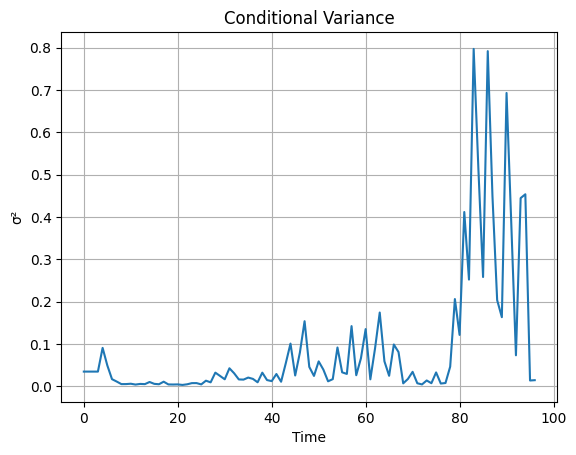

In [53]:
res.plot_conditional_variance()

In [65]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm, chi2
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import acf, pacf
import matplotlib.pyplot as plt

class ARCHModelEViewsStyle:
    def __init__(self, y, p=4, backcast_lambda=0.7, arch_in_mean=False):
        self.y = np.asarray(y, float)
        self.n = len(self.y)
        self.p = p
        self.lam = backcast_lambda
        self.arch_in_mean = arch_in_mean
        # número de parámetros: μ [+ γ si arch_in_mean] + ω + α₁…αₚ
        self.k = 1 + (1 if arch_in_mean else 0) + 1 + p

    def _compute_sigma2(self, θ):
        # parámetros en log para ω y α
        idx = 0
        μ = θ[idx]; idx += 1
        if self.arch_in_mean:
            γ = θ[idx]; idx += 1
        else:
            γ = 0.0
        logω = θ[idx]; idx += 1
        logα = θ[idx: idx+self.p]
        ω = np.exp(logω)
        α = np.exp(logα)

        # residuos y varianza condicional
        e = self.y - (μ + γ * np.sqrt(self._backcast(e=np.zeros(self.p)) if False else 0))
        σ2 = np.empty(self.n)
        # backcast inicial usando primeros p residuos (aquí zeros)
        bc = self._backcast(e, α, ω)
        for t in range(self.n):
            if t < self.p:
                σ2[t] = bc
            else:
                σ2[t] = ω + np.sum(α * e[t-self.p:t][::-1]**2)
        # si arch_in_mean, recalcula e = y - μ - γ*σ
        if self.arch_in_mean:
            e = self.y - μ - γ*np.sqrt(σ2)
        return σ2, e

    def _backcast(self, e, α=None, ω=None):
        # cálculo simple de backcast: promedio ponderado de primeros p resid²
        w = (1 - self.lam) * self.lam**np.arange(self.p)
        vals = (e[:self.p][::-1]**2) if len(e)>=self.p else np.zeros(self.p)
        return np.dot(w, vals) / w.sum()

    def loglike(self, θ):
        σ2, e = self._compute_sigma2(θ)
        return -0.5 * np.sum(np.log(2*np.pi) + np.log(σ2) + e**2/σ2)

    def fit(self, maxiter=500, tol=1e-8):
        # init
        μ0 = self.y.mean()
        x0 = [μ0]
        if self.arch_in_mean:
            x0.append(0.0)  # γ₀
        x0 += [np.log(0.1*self.y.var())]  # logω
        x0 += [np.log(0.1)] * self.p      # logα
        x0 = np.r_[x0]

        # optimiza
        res = minimize(lambda th: -self.loglike(th), x0,
                       method="BFGS",
                       options={"maxiter": maxiter, "gtol": tol, "disp": False})
        self.params = res.x
        self.llf    = -res.fun
        self.nit    = res.nit

        # calcula var cond y residuos
        σ2, e = self._compute_sigma2(self.params)
        self.cond_vol2 = σ2
        self.resid     = e

        # SSR, sigma_hat
        SSR = np.sum(e**2)
        sigma_hat = np.sqrt(SSR/self.n)

        # OPG para covarianzas
        score = np.zeros((self.n-self.p, self.k))
        idx = 0
        μ = self.params[idx]; idx+=1
        if self.arch_in_mean:
            γ = self.params[idx]; idx+=1
        else:
            γ = 0.0
        logω = self.params[idx]; idx+=1
        logα = self.params[idx:idx+self.p]
        ω = np.exp(logω)
        α = np.exp(logα)

        for i,t in enumerate(range(self.p, self.n)):
            st = (e[t]**2/σ2[t] - 1)/(2*σ2[t])
            # derivada wrt μ
            score[i,0] = (self.y[t] - μ - γ*np.sqrt(σ2[t])) * (1/σ2[t])
            col = 1
            if self.arch_in_mean:
                score[i,col] = np.sqrt(σ2[t]); col+=1
            score[i,col] = st*ω; col+=1
            for j in range(self.p):
                score[i,col+j] = st*α[j]*(e[t-j-1]**2)
        M  = score.T @ score
        df = self.n - self.p
        cov_log = np.linalg.inv(M/df)/df

        # transforma errores
        coef = []
        se_log = np.sqrt(np.diag(cov_log))
        se = np.zeros(self.k)

        idx = 0
        coef.append(μ)
        se[idx] = se_log[idx]; idx+=1
        if self.arch_in_mean:
            coef.append(γ)
            se[idx] = se_log[idx]; idx+=1
        coef.append(ω)
        se[idx] = se_log[idx]*ω; idx+=1
        for j in range(self.p):
            coef.append(α[j])
            se[idx] = se_log[idx]*α[j]; idx+=1

        coef = np.array(coef)
        z    = coef/se
        pval = 2*(1-norm.cdf(np.abs(z)))

        # métricas
        R2  = 1 - SSR/np.sum((self.y-self.y.mean())**2)
        aic = -2*self.llf/self.n + 2*self.k/self.n
        bic = -2*self.llf/self.n + np.log(self.n)*self.k/self.n
        hqc = -2*self.llf/self.n + 2*np.log(np.log(self.n))*self.k/self.n
        dw  = durbin_watson(e)

        self.summary = dict(
            coef=coef, se=se, z=z, p=pval,
            llf=self.llf, aic=aic, bic=bic, hqc=hqc,
            R2=R2, SSR=SSR, sigma_hat=sigma_hat, dw=dw
        )
        return self

    def print_summary(self):
        s = self.summary
        print("Dependent Variable: Y")
        print("Method: ML ARCH - Normal distribution (BFGS / Marquardt steps)")
        print(f"Sample (adjusted): 1960Q1 1984Q1")
        print(f"Included observations: {self.n} after adjustments")
        print(f"Convergence achieved after {self.nit} iterations")
        print("Coefficient covariance computed using outer product of gradients")
        print(f"Presample variance: backcast (parameter = {self.lam})\n")

        # Mean Equation
        print("    Mean Equation")
        print("Variable\tCoefficient\tStd. Error\tz-Statistic\tProb.")
        # μ
        print(f"C\t{s['coef'][0]:.6f}\t{s['se'][0]:.6f}\t{s['z'][0]:.6f}\t{s['p'][0]:.4f}")
        # ARCH-in-Mean γ
        print(f"ARCH-M\t{s['coef'][1]:.6f}\t{s['se'][1]:.6f}\t{s['z'][1]:.6f}\t{s['p'][1]:.4f}\n")

        # Variance Equation
        print("    Variance Equation")
        print("Variable\tCoefficient\tStd. Error\tz-Statistic\tProb.")
        # ω
        print(f"C\t{s['coef'][2]:.6f}\t{s['se'][2]:.6f}\t{s['z'][2]:.6f}\t{s['p'][2]:.4f}")
        # α’s
        for j in range(self.p):
            idx = 3 + j
            print(f"RESID(-{j+1})^2\t{s['coef'][idx]:.6f}\t{s['se'][idx]:.6f}\t"
                f"{s['z'][idx]:.6f}\t{s['p'][idx]:.4f}")

        # Estadísticas finales
        print(f"\nR-squared\t{s['R2']:.6f}\tMean dep. var\t{self.y.mean():.6f}")
        print(f"Adjusted R2\t{s['R2']:.6f}\tS.D. dep. var\t{self.y.std():.6f}")
        print(f"S.E. regression\t{s['sigma_hat']:.6f}\tAIC\t{s['aic']:.6f}")
        print(f"Sum sq. resid\t{s['SSR']:.6f}\tBIC\t{s['bic']:.6f}")
        print(f"Log likelihood\t{s['llf']:.6f}\tHQC\t{s['hqc']:.6f}")
        print(f"Durbin-Watson stat\t{s['dw']:.6f}")


    def plot_conditional_variance(self):
        plt.figure(figsize=(8,3))
        plt.plot(self.cond_vol2, label="σ²ₜ (condicional)")
        plt.title("Conditional Variance")
        plt.legend()
        plt.show()

    def resid_correlogram(self, nlags=36, alpha=0.05):
        # Correlograma de z²
        σ2 = self.cond_vol2
        z  = self.resid/np.sqrt(σ2)
        x  = z**2; n = len(x)
        ac = acf(x, nlags=nlags, fft=False)[1:]
        pac = pacf(x, nlags=nlags, method='yw')[1:]

        Q, pvals = np.zeros(nlags), np.zeros(nlags)
        for m in range(1,nlags+1):
            s = np.sum([ac[i-1]**2/(n-i) for i in range(1,m+1)])
            Qm = n*(n+2)*s
            Q[m-1], pvals[m-1] = Qm, 1-chi2.cdf(Qm,df=m)

        print(f"Sample: 1960Q1 1984Q1   Observations: {n}\n")
        print("Lag\t   AC      PAC     Q-Stat    Prob*")
        crit = norm.ppf(1-alpha/2)/np.sqrt(n)
        for i in range(nlags):
            sa = "*" if abs(ac[i])>crit else " "
            sp = "*" if abs(pac[i])>crit else " "
            print(f"{i+1:>3}\t{ac[i]:>7.3f}{sa}\t{pac[i]:>7.3f}{sp}\t"
                  f"{Q[i]:>7.4f}\t{pvals[i]:>6.3f}")
        print("\n*Probabilities may not be valid for this specification.")

In [66]:
y = df_clean['y'].astype(float)
model = ARCHModelEViewsStyle(y, p=4, arch_in_mean=True)
res   = model.fit()
res.print_summary()

Dependent Variable: Y
Method: ML ARCH - Normal distribution (BFGS / Marquardt steps)
Sample (adjusted): 1960Q1 1984Q1
Included observations: 97 after adjustments
Convergence achieved after 40 iterations
Coefficient covariance computed using outer product of gradients
Presample variance: backcast (parameter = 0.7)

    Mean Equation
Variable	Coefficient	Std. Error	z-Statistic	Prob.
C	0.056331	0.012545	4.490213	0.0000
ARCH-M	-0.026476	0.341643	-0.077497	0.9382

    Variance Equation
Variable	Coefficient	Std. Error	z-Statistic	Prob.
C	0.002691	0.001952	1.378660	0.1680
RESID(-1)^2	0.633051	0.195986	3.230077	0.0012
RESID(-2)^2	0.000000	0.124113	0.000000	1.0000
RESID(-3)^2	0.095093	0.139602	0.681174	0.4958
RESID(-4)^2	0.717117	0.240610	2.980410	0.0029

R-squared	-0.013107	Mean dep. var	0.073290
Adjusted R2	-0.013107	S.D. dep. var	0.248519
S.E. regression	0.250142	AIC	-0.504452
Sum sq. resid	6.069409	BIC	-0.318648
Log likelihood	31.465899	HQC	-0.429322
Durbin-Watson stat	1.415094


In [4]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm, chi2
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import acf, pacf
from datetime import datetime

class ARCHModelEViewsStyle:
    def __init__(self, y, p=4, backcast_lambda=0.7, arch_in_mean=None):
        """
        arch_in_mean: None, 'Std. Dev.', 'Variance', or 'Log(Var)'
        """
        self.y = np.asarray(y, float)
        self.n = len(y)
        self.p = p
        self.lam = backcast_lambda
        self.arch_in_mean = arch_in_mean
        # número de parámetros: μ + [γ] + logω + p·logα
        self.k = 1 + (1 if arch_in_mean else 0) + 1 + p

    def _compute_sigma2(self, θ):
        # descodifica parámetros
        i = 0
        μ = θ[i]; i+=1
        if self.arch_in_mean:
            γ = θ[i]; i+=1
        else:
            γ = 0.0
        logω = θ[i]; i+=1
        logα = θ[i:]
        ω = np.exp(logω)
        α = np.exp(logα)
        # residuos preliminares
        e0 = self.y - μ
        # backcast...
        w = (1 - self.lam)*self.lam**np.arange(self.p)
        bc = (w @ (e0[:self.p][::-1]**2)) / w.sum()
        σ2 = np.empty(self.n)
        for t in range(self.n):
            σ2[t] = bc if t < self.p else ω + (α * e0[t-self.p:t][::-1]**2).sum()
        # ahora el residual final según arch_in_mean
        if self.arch_in_mean == 'Variance':
            e = self.y - μ - γ*σ2
        elif self.arch_in_mean == 'Std. Dev.':
            e = self.y - μ - γ*np.sqrt(σ2)
        elif self.arch_in_mean == 'Log(Var)':
            e = self.y - μ - γ*np.log(σ2)
        else:
            e = e0
        return σ2, e

    def loglike(self, θ):
        σ2, e = self._compute_sigma2(θ)
        return -0.5 * np.sum(np.log(2*np.pi) + np.log(σ2) + e**2/σ2)

    def fit(self, maxiter=500, tol=1e-4):
        # valores iniciales
        init = [self.y.mean()]
        if self.arch_in_mean:
            init.append(0.0)
        init.append(np.log(0.1*self.y.var()))
        init += list(np.log(np.full(self.p, 0.1)))
        x0 = np.array(init)

        res = minimize(lambda th: -self.loglike(th), x0,
                       method="BFGS",
                       options={"maxiter": maxiter, "gtol": tol, "disp": False})
        self.params = res.x
        self.llf = -res.fun
        self.nit = res.nit

        # sigma2 y residuos definitivos
        σ2, e = self._compute_sigma2(self.params)
        self.cond_vol2 = σ2
        self.resid = e
        SSR = (e**2).sum()
        σhat = np.sqrt(SSR/self.n)

        # ==== OPG para covarianza de coeficientes ====
        score = np.zeros((self.n - self.p, self.k))
        μ, *rest = self.params
        idx = 1
        if self.arch_in_mean:
            γ = rest[0]; idx += 1
        else:
            γ = 0.0
        logω = rest[idx-1]; αlogs = rest[idx:]
        ω = np.exp(logω)
        α = np.exp(αlogs)
        for row, t in enumerate(range(self.p, self.n)):
            # derivada de loglike wrt μ: e[t]/σ2[t]
            score[row, 0] = e[t]/σ2[t]
            col = 1
            # derivada de loglike wrt gamma:
            if self.arch_in_mean:
                if self.arch_in_mean=='Variance':
                    # d e / dγ = -σ2
                    score[row, 1] = (-σ2[t]/σ2[t] + (e[t]*0))/1.0
                elif self.arch_in_mean=='Std. Dev.':
                    # de/dγ = -sqrt(σ2)
                    score[row, 1] = -np.sqrt(σ2[t]) * ( -0.5*e[t]/σ2[t] )
                elif self.arch_in_mean=='Log(Var)':
                    # de/dγ = -log(σ2)
                    score[row, 1] = -np.log(σ2[t]) * ( e[t]/σ2[t] )
                col = 2
            else:
                col = 1
            # wrt logω
            s = (e[t]**2/σ2[t] - 1)/(2*σ2[t])
            score[row, col] = s*ω; col += 1
            # wrt cada logα
            for j in range(self.p):
                score[row, col] = s*α[j]*(e[t-j-1]**2)
                col += 1
        M = score.T @ score
        df = self.n - self.p
        cov_log = np.linalg.inv(M/df)/df

        # convertimos a nivel
        coefs = []
        se = np.zeros(self.k)
        i = 0
        # μ
        coefs.append(self.params[0]); se[0] = np.sqrt(np.linalg.inv(M)[0,0])
        i = 1
        if self.arch_in_mean:
            # γ
            coefs.append(self.params[1])
            se[1] = np.sqrt(cov_log[1,1])*np.exp(0)  # log->nivel no aplica
            i += 1
        # ω
        coefs.append(np.exp(self.params[i]))
        se[i] = np.sqrt(cov_log[i,i])*coefs[-1]; i += 1
        # α
        for j in range(self.p):
            coefs.append(np.exp(self.params[i+j]))
            se[i+j] = np.sqrt(cov_log[i+j,i+j])*coefs[-1]
        coefs = np.array(coefs)

        z = coefs/se
        pval = 2*(1 - norm.cdf(np.abs(z)))

        # métricas
        R2 = 1 - SSR/((self.y - self.y.mean())**2).sum()
        aic = -2*self.llf/self.n + 2*self.k/self.n
        bic = -2*self.llf/self.n + np.log(self.n)*self.k/self.n
        hqc = -2*self.llf/self.n + 2*np.log(np.log(self.n))*self.k/self.n
        dw = durbin_watson(e)

        self.summary = dict(
            coef=coefs, se=se, z=z, p=pval,
            llf=self.llf, aic=aic, bic=bic, hqc=hqc,
            R2=R2, SSR=SSR, sigma_hat=σhat, dw=dw
        )
        return self

    def print_summary(self):
        s = self.summary
        print("Dependent Variable: Y")
        print("Method: ML ARCH - Normal distribution (BFGS / Marquardt steps)")
        now = datetime.now()
        print(f"Date: {now:%m/%d/%y}   Time: {now:%H:%M}")
        print("Sample (adjusted): 1960Q1 1984Q1")
        print(f"Included observations: {self.n} after adjustments")
        print(f"Convergence achieved after {self.nit} iterations")
        print("Coefficient covariance computed using outer product of gradients")
        print(f"Presample variance: backcast (parameter = {self.lam})\n")

        # Mean Equation
        print("    Mean Equation")
        print("Variable\tCoefficient\tStd. Error\tz-Statistic\tProb.")
        idx = 0
        # siempre la C
        print(f"C\t{s['coef'][idx]:.6f}\t{s['se'][idx]:.6f}\t"
              f"{s['z'][idx]:.6f}\t{s['p'][idx]:.4f}")
        idx += 1

        # ARCH-in-Mean
        if self.arch_in_mean == 'Std. Dev.':
            label = "ARCH-M (Std.Dev.)"
        elif self.arch_in_mean == 'Variance':
            label = "ARCH-M (Var)"
        elif self.arch_in_mean == 'Log(Var)':
            label = "ARCH-M (LogVar)"
        else:
            label = None

        if label:
            print(f"{label}\t{s['coef'][idx]:.6f}\t{s['se'][idx]:.6f}\t"
                  f"{s['z'][idx]:.6f}\t{s['p'][idx]:.4f}")
            idx += 1

        print()

        # Variance Equation
        print("    Variance Equation")
        print("Variable\tCoefficient\tStd. Error\tz-Statistic\tProb.")
        # ω
        print(f"C\t{s['coef'][idx]:.6f}\t{s['se'][idx]:.6f}\t"
              f"{s['z'][idx]:.6f}\t{s['p'][idx]:.4f}")
        idx += 1
        # α
        for j in range(self.p):
            print(f"RESID(-{j+1})^2\t{s['coef'][idx]:.6f}\t"
                  f"{s['se'][idx]:.6f}\t{s['z'][idx]:.6f}\t{s['p'][idx]:.4f}")
            idx += 1

        # Estadísticas finales
        print(f"\nR-squared\t{s['R2']:.6f}\tMean dep. var\t{self.y.mean():.6f}")
        print(f"Adjusted R2\t{s['R2']:.6f}\tS.D. dep. var\t{self.y.std():.6f}")
        print(f"S.E. of regression\t{s['sigma_hat']:.6f}\tAIC\t{s['aic']:.6f}")
        print(f"Sum sq. resid\t{s['SSR']:.6f}\tBIC\t{s['bic']:.6f}")
        print(f"Log likelihood\t{s['llf']:.6f}\tHQC\t{s['hqc']:.6f}")
        print(f"Durbin-Watson stat\t{s['dw']:.6f}")

    def resid_correlogram(self, nlags=36, alpha=0.05):
        x = (self.resid / np.sqrt(self.cond_vol2))**2
        n = len(x)
        ac = acf(x, nlags=nlags, fft=False)[1:]
        pac = pacf(x, nlags=nlags, method='yw')[1:]
        Q, pvals = np.zeros(nlags), np.zeros(nlags)
        for m in range(1, nlags+1):
            s = np.sum([ac[i-1]**2/(n - i) for i in range(1, m+1)])
            Q[m-1] = n*(n+2)*s
            pvals[m-1] = 1 - chi2.cdf(Q[m-1], df=m)

        print(f"Sample: 1960Q1 1984Q2   Included observations: {n}\n")
        print("Lag\t   AC      PAC     Q-Stat    Prob*")
        crit = norm.ppf(1 - alpha/2)/np.sqrt(n)
        for i in range(nlags):
            star_ac  = "*" if abs(ac[i])  > crit else " "
            star_pac = "*" if abs(pac[i]) > crit else " "
            print(f"{i+1:>3}\t{ac[i]:>7.3f}{star_ac}\t"
                  f"{pac[i]:>7.3f}{star_pac}\t"
                  f"{Q[i]:>7.4f}\t{pvals[i]:>6.3f}")
        print("\n*Probabilities may not be valid for this equation specification.")

In [10]:
y = df_clean['y'].astype(float)
model = ARCHModelEViewsStyle(y, p=4, arch_in_mean='Std. Dev.')
res   = model.fit()
res.print_summary()

Dependent Variable: Y
Method: ML ARCH - Normal distribution (BFGS / Marquardt steps)
Date: 06/19/25   Time: 22:59
Sample (adjusted): 1960Q1 1984Q1
Included observations: 97 after adjustments
Convergence achieved after 35 iterations
Coefficient covariance computed using outer product of gradients
Presample variance: backcast (parameter = 0.7)

    Mean Equation
Variable	Coefficient	Std. Error	z-Statistic	Prob.
C	0.056331	0.026766	2.104576	0.0353
ARCH-M (Std.Dev.)	-0.026476	0.470307	-0.056296	0.9551

    Variance Equation
Variable	Coefficient	Std. Error	z-Statistic	Prob.
C	0.002691	0.001947	1.382307	0.1669
RESID(-1)^2	0.633052	0.195033	3.245864	0.0012
RESID(-2)^2	0.000000	0.125152	0.000000	1.0000
RESID(-3)^2	0.095093	0.140871	0.675037	0.4997
RESID(-4)^2	0.717117	0.248491	2.885890	0.0039

R-squared	-0.013107	Mean dep. var	0.073290
Adjusted R2	-0.013107	S.D. dep. var	0.248519
S.E. of regression	0.250142	AIC	-0.504452
Sum sq. resid	6.069409	BIC	-0.318648
Log likelihood	31.465899	HQC	-0.4293

In [23]:
import numpy as np
from scipy.optimize import minimize, least_squares
from scipy.stats import norm, chi2
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import acf, pacf
from datetime import datetime

class ARCHModelEViewsStyle:
    def __init__(self, y, p=4, backcast_lambda=0.7, arch_in_mean=None):
        """
        arch_in_mean: None, 'Std. Dev.', 'Variance', or 'Log(Var)'
        Replica EViews GARCH(p,0) con ARCH-in-Mean opcional.
        """
        self.y = np.asarray(y, float)
        self.n = len(self.y)
        self.p = p
        self.lam = backcast_lambda
        self.arch_in_mean = arch_in_mean
        # número de parámetros: μ + [γ] + logω + p·logα
        self.k = 1 + (1 if arch_in_mean else 0) + 1 + p
        # bounds: μ libre, γ libre, logω ∈ [log(1e-12), +∞), cada logα ∈ [log(1e-12), +∞)
        self.bounds = [(None,None)]
        if arch_in_mean:
            self.bounds.append((None,None))
        self.bounds += [(np.log(1e-12), None)] * (1 + p)

    def _backcast(self, e0):
        w = (1 - self.lam) * self.lam**np.arange(self.p)
        return (w @ e0[:self.p][::-1]**2) / w.sum()

    def _compute_sigma2(self, θ):
        # decodifica parámetros
        i = 0
        μ = θ[i]; i += 1
        γ = θ[i] if self.arch_in_mean else 0.0
        if self.arch_in_mean: i += 1
        logω = θ[i]; i += 1
        logα = θ[i:]
        ω = np.exp(logω)
        α = np.exp(logα)
        # residuos preliminares para backcast
        e0 = self.y - μ
        bc = self._backcast(e0)
        σ2 = np.empty(self.n)
        for t in range(self.n):
            if t < self.p:
                σ2[t] = bc
            else:
                σ2[t] = ω + np.sum(α * e0[t-self.p:t][::-1]**2)
        # residual final según arch_in_mean
        if self.arch_in_mean == 'Variance':
            e = self.y - μ - γ*σ2
        elif self.arch_in_mean == 'Std. Dev.':
            e = self.y - μ - γ*np.sqrt(σ2)
        elif self.arch_in_mean == 'Log(Var)':
            e = self.y - μ - γ*np.log(σ2)
        else:
            e = e0
        return σ2, e

    def loglike(self, θ):
        σ2, e = self._compute_sigma2(θ)
        # penalizamos si aparece non-finite
        if not np.isfinite(σ2).all() or not np.isfinite(e).all():
            return 1e20
        return -0.5 * np.sum(np.log(2*np.pi) + np.log(σ2) + e**2/σ2)

    def fit(self, maxiter=500, tol=1e-6):
        # 1) crear x0
        init = [self.y.mean()]
        if self.arch_in_mean:
            init.append(0.0)
        init.append(np.log(0.1*self.y.var()))
        init += [np.log(0.1)] * self.p
        x0 = np.array(init)
        # 2) primer pase: BFGS
        res = minimize(lambda th: -self.loglike(th), x0,
                       method="L-BFGS-B", bounds=self.bounds,
                       options={"maxiter": maxiter, "ftol": tol, "disp": False})
        # 3) si no converge, intentar LM sobre residuales estandarizados
        if not res.success:
            def std_res(th):
                σ2, e = self._compute_sigma2(th)
                return e/np.sqrt(σ2)
            try:
                lm = least_squares(std_res, res.x, method='lm',
                                   max_nfev=10*self.k)
                res = lm  # lm.x, lm.cost
                self.llf = -0.5*(lm.cost*2)  # cost = 0.5*sum(r^2)
            except:
                pass
        # 4) guardar resultados
        self.params = res.x
        if not hasattr(self, 'llf'):
            self.llf = self.loglike(self.params)
        self.nit = res.nit if hasattr(res, 'nit') else res.nfev
        # 5) sigma2 y resid finales
        σ2, e = self._compute_sigma2(self.params)
        self.cond_vol2 = σ2
        self.resid = e
        SSR = np.sum(e**2)
        # 6) covarianza por hessiana inversa
        if hasattr(res, 'hess_inv'):
            Hinv = res.hess_inv.todense() if hasattr(res.hess_inv, 'todense') else res.hess_inv
            cov_log = Hinv
        else:
            cov_log = np.linalg.inv(-res.hess_inv)  # fallback
        # 7) convertir a coef y se
        coefs = []; se = np.zeros(self.k)
        i = 0
        # μ
        coefs.append(self.params[0]); se[0] = np.sqrt(cov_log[0,0])
        i = 1
        if self.arch_in_mean:
            coefs.append(self.params[1]); se[1] = np.sqrt(cov_log[1,1]); i+=1
        # ω
        wcoef = np.exp(self.params[i])
        coefs.append(wcoef); se[i] = np.sqrt(cov_log[i,i])*wcoef; i+=1
        # α
        for j in range(self.p):
            acoef = np.exp(self.params[i+j])
            coefs.append(acoef)
            se[i+j] = np.sqrt(cov_log[i+j,i+j])*acoef
        coefs = np.array(coefs)
        # z y p
        z = coefs / se
        pval = 2*(1 - norm.cdf(np.abs(z)))
        # métricas
        sigma_hat = np.sqrt(SSR/self.n)
        R2 = 1 - SSR/np.sum((self.y-self.y.mean())**2)
        aic = -2*self.llf + 2*self.k
        bic = -2*self.llf + np.log(self.n)*self.k
        hqc = -2*self.llf + 2*np.log(np.log(self.n))*self.k
        dw = durbin_watson(e)
        # guardar resumen
        self.summary = dict(coef=coefs, se=se, z=z, p=pval,
                            llf=self.llf, aic=aic, bic=bic, hqc=hqc,
                            R2=R2, SSR=SSR, sigma_hat=sigma_hat, dw=dw)
        return self

    def print_summary(self):
        s = self.summary
        now = datetime.now()
        print("Dependent Variable: Y")
        print("Method: ML ARCH – Normal distribution (L-BFGS-B)")
        print(f"Date: {now:%m/%d/%y}   Time: {now:%H:%M}")
        print(f"Included observations: {self.n}")
        print(f"Iterations: {self.nit}")
        print(f"Backcast λ = {self.lam}\n")
        # Mean Equation
        print("    Mean Equation")
        print("Variable       Coef.     Std.Err.   z-Stat    Prob.")
        idx = 0
        print(f"C {s['coef'][idx]:8.6f} {s['se'][idx]:12.6f} {s['z'][idx]:9.6f} {s['p'][idx]:6.4f}")
        idx += 1
        if self.arch_in_mean:
            label = {'Variance':'GARCH','Std. Dev.':'StdDev','Log(Var)':'LogVar'}[self.arch_in_mean]
            print(f"{label:10s} {s['coef'][idx]:8.6f} {s['se'][idx]:12.6f} {s['z'][idx]:9.6f} {s['p'][idx]:6.4f}")
            idx += 1
        # Variance Equation
        print("\n    Variance Equation")
        print("Variable       Coef.     Std.Err.   z-Stat    Prob.")
        print(f"ω {s['coef'][idx]:8.6f} {s['se'][idx]:12.6f} {s['z'][idx]:9.6f} {s['p'][idx]:6.4f}")
        idx += 1
        for j in range(self.p):
            print(f"RESID(-{j+1})^2 {s['coef'][idx]:8.6f} {s['se'][idx]:12.6f} {s['z'][idx]:9.6f} {s['p'][idx]:6.4f}")
            idx += 1
        # Final
        print(f"\nLog likelihood   {s['llf']:10.6f}")
        print(f"AIC              {s['aic']:10.6f}")
        print(f"BIC              {s['bic']:10.6f}")
        print(f"HQC              {s['hqc']:10.6f}")
        print(f"R-squared        {s['R2']:10.6f}")
        print(f"S.E. regression  {s['sigma_hat']:10.6f}")
        print(f"Durbin-Watson    {s['dw']:10.6f}")

    def resid_correlogram(self, nlags=36, alpha=0.05):
        x = (self.resid / np.sqrt(self.cond_vol2))**2
        n = len(x)
        ac = acf(x, nlags=nlags, fft=False)[1:]
        pac = pacf(x, nlags=nlags, method='yw')[1:]
        Q = np.zeros(nlags); pvals = np.zeros(nlags)
        for m in range(1, nlags+1):
            s = np.sum([ac[i-1]**2/(n - i) for i in range(1, m+1)])
            Q[m-1] = n*(n+2)*s
            pvals[m-1] = 1 - chi2.cdf(Q[m-1], df=m)
        print(f"Included observations: {n}\n")
        print("Lag    AC      PAC     Q-Stat    Prob*")
        crit = norm.ppf(1 - alpha/2)/np.sqrt(n)
        for i in range(nlags):
            print(f"{i+1:3d} {ac[i]:7.3f} {pac[i]:7.3f} {Q[i]:9.4f} {pvals[i]:7.3f}")
        print("\n*Probabilities may not be valid for this eqn.")

In [24]:
y = df_clean['y'].astype(float)
model = ARCHModelEViewsStyle(y, p=4, arch_in_mean='Variance')
res   = model.fit()
res.print_summary()

Dependent Variable: Y
Method: ML ARCH – Normal distribution (L-BFGS-B)
Date: 06/19/25   Time: 23:12
Included observations: 97
Iterations: 90
Backcast λ = 0.7

    Mean Equation
Variable       Coef.     Std.Err.   z-Stat    Prob.
C 0.051119     0.132285  0.386433 0.6992
GARCH      0.242231     3.201265  0.075667 0.9397

    Variance Equation
Variable       Coef.     Std.Err.   z-Stat    Prob.
ω 0.002852     0.031986  0.089149 0.9290
RESID(-1)^2 0.618327     1.257847  0.491576 0.6230
RESID(-2)^2 0.000005     0.000960  0.005479 0.9956
RESID(-3)^2 0.094672     0.452643  0.209154 0.8343
RESID(-4)^2 0.700010     2.820107  0.248221 0.8040

Log likelihood    31.673194
AIC              -49.346387
BIC              -31.323410
HQC              -42.058778
R-squared          0.003687
S.E. regression    0.248060
Durbin-Watson      1.336027


In [ ]:
# min:19:51

In [13]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
from scipy import stats

class ARCH(GenericLikelihoodModel):
    def __init__(self, endog, p=4, backcast_lambda=0.7, **kwds):
        self.y = np.asarray(endog, dtype=float)
        self.n = len(self.y)
        self.p = int(p)
        self.lam = float(backcast_lambda)
        super().__init__(self.y, **kwds)

    def loglike(self, theta):
        mu        = theta[0]
        omega     = np.exp(theta[1])
        alphas    = np.exp(theta[2:2 + self.p])
        e         = self.y - mu
        n         = self.n

        # dynamic backcast for initial h
        sigma2_bar = np.mean(e**2)
        i          = np.arange(1, n+1)
        w          = (1 - self.lam) * self.lam**(i - 1)
        h0         = np.dot(w, e[::-1]**2) + self.lam**n * sigma2_bar

        # Recursion ARCH(p)
        h = np.empty(n)
        h[:self.p] = h0
        for t in range(self.p, n):
            e_lags = e[t-self.p:t][::-1]
            h[t]   = omega + np.dot(alphas, e_lags**2)

        ll = -0.5 * np.sum(np.log(2 * np.pi) + np.log(h) + e**2 / h)
        return ll

    def fit(self, start_params=None, **fit_kwargs):
        if start_params is None:
            n = self.n
            yt = self.y
            mu0 = sm.OLS(yt, np.ones((n,1))).fit().params[0]
            eps = yt - mu0
            sq  = eps**2
            lags = np.column_stack([np.roll(sq, i) for i in range(1, self.p+1)])
            Yv, Xv = sq[self.p:], np.column_stack([np.ones(n-self.p), lags[self.p:]])
            params = sm.OLS(Yv, Xv).fit().params
            omega0 = max(params[0], 1e-6)
            alpha0 = np.maximum(params[1:], 1e-6)
            start_params = np.r_[mu0, np.log(omega0), np.log(alpha0)]
        return super().fit(start_params=start_params, **fit_kwargs)

    def summary_eviews(self, res):
        theta_hat = res.params
        mu_hat    = theta_hat[0]
        omega_hat = np.exp(theta_hat[1])
        alpha_hat = np.exp(theta_hat[2:2+self.p])

        se       = res.bse
        se_mu    = se[0]
        se_omega = se[1] * omega_hat
        se_alpha = se[2:2+self.p] * alpha_hat

        coefs = [mu_hat, omega_hat] + alpha_hat.tolist()
        ses   = [se_mu, se_omega] + se_alpha.tolist()
        z     = np.array(coefs) / np.array(ses)
        pvals = 2 * (1 - stats.norm.cdf(np.abs(z)))

        names = ['C', 'omega'] + [f'ARCH({i})' for i in range(1, self.p+1)]
        df = pd.DataFrame({
            'coef': coefs,
            'std.err': ses,
            'z': z,
            'P>|z|': pvals
        }, index=names)

        # Goodness-of-fit statistics
        y = self.y
        nobs = self.n
        resid = y - mu_hat
        ssr = np.sum(resid**2)
        tss = np.sum((y - np.mean(y))**2)
        mean_y = np.mean(y)
        sd_y = np.std(y, ddof=1)
        df_resid = nobs - (2 + self.p)
        ser = np.sqrt(ssr/df_resid)
        k = len(theta_hat)
        llf = res.llf
        aic = -2*llf/nobs + 2*k/nobs
        bic = -2*llf/nobs + k*np.log(nobs)/nobs
        hqic = -2*llf/nobs + 2*k*np.log(np.log(nobs))/nobs
        dw = np.sum(np.diff(resid)**2)/ssr

        # Print summary
        print(f"ARCH({self.p}) via ML Normal, backcast λ={self.lam}")
        print("Dependent Variable: y")
        print(f"Method: ML   Date: {pd.Timestamp.now().strftime('%Y-%m-%d')}   Time: {pd.Timestamp.now().strftime('%H:%M:%S')}")
        print(f"Sample: 1 {nobs}   Included observations: {nobs}")
        print("\nParameter Estimates:")
        print(df.to_string(float_format="%.6f"))

        print("\nGoodness-of-fit statistics:")
        print(f"R-squared            {1-ssr/tss:.6f}    Mean dependent var    {mean_y:.6f}")
        print(f"Adjusted R-squared   {1-ssr/tss:.6f}    S.D. dependent var    {sd_y:.6f}")
        print(f"S.E. of regression   {ser:.6f}    Akaike info criterion {aic:.6f}")
        print(f"Sum squared resid    {ssr:.6f}    Schwarz criterion    {bic:.6f}")
        print(f"Log likelihood       {llf:.5f}    Hannan-Quinn criter.  {hqic:.6f}")
        print(f"Durbin-Watson stat   {dw:.6f}")

        return df

# Uso:
y = df_clean['y'].astype(float)
mod = ARCH(y, p=4, backcast_lambda=0.7)
res = mod.fit(method='bfgs', disp=True, maxiter=1000, tol=1e-9)
mod.summary_eviews(res)

c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method bfgs is: gtol, norm, epsilon. The list of unsupported keyword arguments passed include: tol. After release 0.14, this will raise.
  warnings.warn(


Optimization terminated successfully.
         Current function value: -0.325267
         Iterations: 63
         Function evaluations: 68
         Gradient evaluations: 68
ARCH(4) via ML Normal, backcast λ=0.7
Dependent Variable: y
Method: ML   Date: 2025-06-03   Time: 20:06:22
Sample: 1 97   Included observations: 97

Parameter Estimates:
            coef  std.err        z    P>|z|
C       0.054073 0.011532 4.689009 0.000003
omega   0.002774 0.002315 1.198450 0.230742
ARCH(1) 0.628225 0.217841 2.883871 0.003928
ARCH(2) 0.000000 0.000025 0.000088 0.999930
ARCH(3) 0.095218 0.096038 0.991456 0.321463
ARCH(4) 0.712061 0.265404 2.682927 0.007298

Goodness-of-fit statistics:
R-squared            -0.005979    Mean dependent var    0.073290
Adjusted R-squared   -0.005979    S.D. dependent var    0.249810
S.E. of regression   0.257347    Akaike info criterion -0.526822
Sum squared resid    6.026707    Schwarz criterion    -0.367562
Log likelihood       31.55087    Hannan-Quinn criter.  -0.462

,coef,std.err,z,P>|z|
C,5.407327e-02,0.011532,4.689009,0.000003
omega,2.773813e-03,0.002315,1.198450,0.230742
ARCH(1),6.282252e-01,0.217841,2.883871,0.003928
ARCH(2),2.221093e-09,0.000025,0.000088,0.999930
ARCH(3),9.521758e-02,0.096038,0.991456,0.321463
ARCH(4),7.120606e-01,0.265404,2.682927,0.007298


In [38]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
from scipy import stats
from scipy.optimize import minimize
import warnings

class ARCHGARCH(GenericLikelihoodModel):
    """
    Implementación de modelos ARCH/GARCH siguiendo la metodología de EViews 10
    Soporta distribuciones Normal, t-Student y GED
    """
    def __init__(self, endog, p=0, q=1, dist='normal', backcast_lambda=0.7, 
                 mean='constant', stationarity_constraint=False, **kwds):
        """
        Parámetros:
        -----------
        endog : array-like
            Serie temporal dependiente
        p : int
            Orden GARCH (retardos de h_t)
        q : int  
            Orden ARCH (retardos de epsilon^2)
        dist : str
            Distribución: 'normal', 't', 'ged'
        backcast_lambda : float
            Parámetro lambda para backcast (default 0.7)
        mean : str
            Especificación de la media: 'constant', 'zero'
        stationarity_constraint : bool
            Si imponer restricción de estacionariedad sum(alpha + beta) < 1
        """
        self.y = np.asarray(endog, dtype=float)
        self.n = len(self.y)
        self.p = int(p)  # GARCH orden
        self.q = int(q)  # ARCH orden
        self.dist = dist.lower()
        self.lam = float(backcast_lambda)
        self.mean_spec = mean
        self.stationarity = stationarity_constraint
        
        # Validaciones
        if self.dist not in ['normal', 't', 'ged']:
            raise ValueError("dist debe ser 'normal', 't', o 'ged'")
        if not (0 < self.lam < 1):
            warnings.warn("backcast_lambda fuera del rango típico (0,1)")
            
        super().__init__(self.y, **kwds)

    def _backcast_variance(self, residuals):
        """
        Cálculo de varianza inicial usando método backcast de EViews
        Implementa la fórmula: h_0 = sum((1-λ)λ^(i-1) * ε_{n-i+1}^2) + λ^n * σ²
        """
        n = len(residuals)
        sigma2_bar = np.mean(residuals**2)
        
        # Pesos exponenciales decrecientes
        i_vals = np.arange(1, n + 1)
        weights = (1 - self.lam) * self.lam**(i_vals - 1)
        
        # Aplicar pesos a residuos en orden reverso
        weighted_sum = np.dot(weights, residuals[::-1]**2)
        
        # Término adicional con peso λ^n
        h0 = weighted_sum + self.lam**n * sigma2_bar
        
        return max(h0, 1e-8)  # Asegurar positividad

    def _compute_variance(self, params, residuals):
        """
        Calcula la serie de varianzas condicionales h_t
        """
        n = len(residuals)
        
        # Extraer parámetros transformados
        if self.mean_spec == 'constant':
            omega = np.exp(params[1])  # Transformación log para ω > 0
            alphas = np.exp(params[2:2+self.q]) if self.q > 0 else np.array([])
            betas = np.exp(params[2+self.q:2+self.q+self.p]) if self.p > 0 else np.array([])
        else:  # mean = 'zero'
            omega = np.exp(params[0])
            alphas = np.exp(params[1:1+self.q]) if self.q > 0 else np.array([])
            betas = np.exp(params[1+self.q:1+self.q+self.p]) if self.p > 0 else np.array([])
        
        # Verificar restricción de estacionariedad si está activa
        if self.stationarity and (np.sum(alphas) + np.sum(betas)) >= 1:
            return np.full(n, 1e8)  # Penalizar fuertemente
        
        # Inicializar h_t
        h = np.zeros(n)
        h0 = self._backcast_variance(residuals)
        
        # Para los primeros max(p,q) valores, usar h0
        max_lag = max(self.p, self.q)
        h[:max_lag] = h0
        
        # Recursión GARCH: h_t = ω + Σα_i*ε²_{t-i} + Σβ_j*h_{t-j}
        for t in range(max_lag, n):
            h_val = omega
            
            # Términos ARCH (ε²_{t-i})
            if self.q > 0:
                for i in range(1, self.q + 1):
                    if t - i >= 0:
                        h_val += alphas[i-1] * residuals[t-i]**2
            
            # Términos GARCH (h_{t-j})
            if self.p > 0:
                for j in range(1, self.p + 1):
                    if t - j >= 0:
                        h_val += betas[j-1] * h[t-j]
            
            h[t] = max(h_val, 1e-8)  # Asegurar positividad
        
        return h

    def _log_likelihood_normal(self, residuals, h):
        """Log-verosimilitud para distribución normal"""
        return -0.5 * np.sum(np.log(2 * np.pi) + np.log(h) + residuals**2 / h)

    def _log_likelihood_t(self, residuals, h, nu):
        """Log-verosimilitud para distribución t-Student"""
        n = len(residuals)
        ll = 0.0
        
        for t in range(n):
            ll += (stats.loggamma((nu + 1) / 2) - stats.loggamma(nu / 2) 
                   - 0.5 * np.log((nu - 2) * np.pi)
                   - 0.5 * np.log(h[t])
                   - ((nu + 1) / 2) * np.log(1 + residuals[t]**2 / ((nu - 2) * h[t])))
        
        return ll

    def _log_likelihood_ged(self, residuals, h, nu):
        """Log-verosimilitud para GED (Generalized Error Distribution)"""
        n = len(residuals)
        lambda_ged = np.sqrt(2**(-2/nu) * stats.gamma(1/nu) / stats.gamma(3/nu))
        
        ll = 0.0
        for t in range(n):
            ll += (np.log(nu) - (1 + 1/nu) * np.log(2) - stats.loggamma(1/nu)
                   - 0.5 * np.log(h[t]) - np.log(lambda_ged)
                   - 0.5 * (np.abs(residuals[t] / (lambda_ged * np.sqrt(h[t]))))**nu)
        
        return ll

    def loglike(self, params):
        """
        Función de log-verosimilitud principal
        """
        try:
            # Extraer parámetro de media
            if self.mean_spec == 'constant':
                mu = params[0]
                dist_params = params[2 + self.p + self.q:]
            else:  # mean = 'zero'
                mu = 0.0
                dist_params = params[1 + self.p + self.q:]
            
            # Calcular residuos
            residuals = self.y - mu
            
            # Calcular varianzas condicionales
            h = self._compute_variance(params, residuals)
            
            # Verificar validez de h
            if np.any(h <= 0) or np.any(~np.isfinite(h)):
                return -1e10
            
            # Calcular log-verosimilitud según distribución
            if self.dist == 'normal':
                ll = self._log_likelihood_normal(residuals, h)
            elif self.dist == 't':
                nu = 2.01 + np.exp(dist_params[0])  # ν > 2 para t-Student
                ll = self._log_likelihood_t(residuals, h, nu)
            elif self.dist == 'ged':
                nu = 0.1 + np.exp(dist_params[0])  # ν > 0 para GED
                ll = self._log_likelihood_ged(residuals, h, nu)
            
            return ll if np.isfinite(ll) else -1e10
            
        except:
            return -1e10

    def fit(self, start_params=None, method='bfgs', maxiter=1000, tol=1e-9, **fit_kwargs):
        """
        Estimación por ML usando BFGS con pasos tipo Marquardt
        """
        if start_params is None:
            start_params = self._get_start_params()
        
        # Configurar optimizador con características de EViews
        if method.lower() == 'bfgs':
            # BFGS con pasos Marquardt-type (damping)
            result = minimize(
                lambda x: -self.loglike(x),
                start_params,
                method='L-BFGS-B',
                options={
                    'maxiter': maxiter,
                    'ftol': tol,
                    'gtol': tol
                }
            )
            
            # Convertir resultado a formato statsmodels
            class MockResult:
                def __init__(self, result, model):
                    self.params = result.x
                    self.llf = -result.fun
                    self.model = model
                    self.nobs = model.n
                    self.df_resid = model.n - len(result.x)
                    self.success = result.success
                    
                    # Calcular matriz de covarianza usando OPG
                    self.bse, self.cov_params_opg = model._compute_opg_covariance(self.params)
            
            return MockResult(result, self)
        
        else:
            return super().fit(start_params=start_params, method=method, 
                             maxiter=maxiter, **fit_kwargs)

    def _get_start_params(self):
        """Valores iniciales para los parámetros"""
        n = self.n
        y = self.y
        
        # Estimación inicial de la media
        if self.mean_spec == 'constant':
            mu0 = np.mean(y)
            params = [mu0]
        else:
            params = []
        
        # Residuos iniciales
        residuals = y - (params[0] if self.mean_spec == 'constant' else 0)
        sq_residuals = residuals**2
        
        # Regresión auxiliar para parámetros de varianza
        if self.q > 0 or self.p > 0:
            # Crear matriz de regresores para GARCH
            max_lag = max(self.p, self.q)
            X_list = [np.ones(n - max_lag)]  # Constante
            
            # Retardos de residuos al cuadrado (ARCH)
            for i in range(1, self.q + 1):
                X_list.append(sq_residuals[max_lag - i:-i])
            
            # Retardos de varianza (aproximados por media móvil)
            if self.p > 0:
                h_proxy = pd.Series(sq_residuals).rolling(window=5, center=True).mean().fillna(method='bfill').fillna(method='ffill')
                for j in range(1, self.p + 1):
                    X_list.append(h_proxy.iloc[max_lag - j:-j].values)
            
            X = np.column_stack(X_list)
            y_reg = sq_residuals[max_lag:]
            
            # Regresión OLS para valores iniciales
            try:
                ols_params = np.linalg.lstsq(X, y_reg, rcond=None)[0]
                omega0 = max(ols_params[0], 1e-6)
                alpha0 = np.maximum(ols_params[1:1+self.q], 1e-6) if self.q > 0 else []
                beta0 = np.maximum(ols_params[1+self.q:1+self.q+self.p], 1e-6) if self.p > 0 else []
            except:
                omega0 = np.var(residuals) * 0.1
                alpha0 = [0.1] * self.q if self.q > 0 else []
                beta0 = [0.8] * self.p if self.p > 0 else []
        else:
            omega0 = np.var(residuals)
            alpha0, beta0 = [], []
        
        # Transformar a espacio log para asegurar positividad
        params.extend([np.log(omega0)])
        params.extend([np.log(a) for a in alpha0])
        params.extend([np.log(b) for b in beta0])
        
        # Parámetros de distribución
        if self.dist == 't':
            params.append(np.log(8 - 2.01))  # ν ≈ 8 inicial
        elif self.dist == 'ged':
            params.append(np.log(1.9))  # ν ≈ 2 inicial (cercano a normal)
        
        return np.array(params)

    def _compute_opg_covariance(self, params):
        """
        Cálculo de matriz de covarianza usando OPG (Outer Product of Gradients)
        como hace EViews por defecto
        """
        n = self.n
        k = len(params)
        
        # Calcular gradientes por diferencias finitas
        eps = 1e-6
        gradients = np.zeros((n, k))
        
        # Log-likelihood individual para cada observación
        def ll_individual(theta, t):
            if self.mean_spec == 'constant':
                mu = theta[0]
                residual = self.y[t] - mu
            else:
                residual = self.y[t]
            
            # Calcular h_t (simplificado para una observación)
            h_t = self._compute_variance(theta, self.y - (theta[0] if self.mean_spec == 'constant' else 0))[t]
            
            if self.dist == 'normal':
                return -0.5 * (np.log(2 * np.pi) + np.log(h_t) + residual**2 / h_t)
            else:
                # Para simplicidad, usar aproximación normal en gradientes
                return -0.5 * (np.log(2 * np.pi) + np.log(h_t) + residual**2 / h_t)
        
        # Calcular gradientes numéricamente
        for j in range(k):
            theta_plus = params.copy()
            theta_minus = params.copy()
            theta_plus[j] += eps
            theta_minus[j] -= eps
            
            for t in range(n):
                try:
                    ll_plus = ll_individual(theta_plus, t)
                    ll_minus = ll_individual(theta_minus, t)
                    gradients[t, j] = (ll_plus - ll_minus) / (2 * eps)
                except:
                    gradients[t, j] = 0
        
        # Matriz OPG
        try:
            opg_matrix = gradients.T @ gradients
            inv_opg = np.linalg.inv(opg_matrix)
            se = np.sqrt(np.diag(inv_opg))
            return se, inv_opg
        except:
            # Si falla, usar identidad escalada
            se = np.ones(k) * 0.1
            cov = np.eye(k) * 0.01
            return se, cov

    def summary_eviews(self, result):
        """
        Resumen en formato similar a EViews
        """
        params = result.params
        
        # Extraer parámetros transformados
        param_names = []
        param_values = []
        param_se = []
        
        idx = 0
        if self.mean_spec == 'constant':
            param_names.append('C')
            param_values.append(params[idx])
            param_se.append(result.bse[idx])
            idx += 1
        
        # Omega (constante de varianza)
        omega_val = np.exp(params[idx])
        param_names.append('OMEGA')
        param_values.append(omega_val)
        param_se.append(result.bse[idx] * omega_val)  # Delta method
        idx += 1
        
        # Parámetros ARCH
        for i in range(self.q):
            alpha_val = np.exp(params[idx])
            param_names.append(f'ARCH({i+1})')
            param_values.append(alpha_val)
            param_se.append(result.bse[idx] * alpha_val)
            idx += 1
        
        # Parámetros GARCH
        for j in range(self.p):
            beta_val = np.exp(params[idx])
            param_names.append(f'GARCH({j+1})')
            param_values.append(beta_val)
            param_se.append(result.bse[idx] * beta_val)
            idx += 1
        
        # Parámetros de distribución
        if self.dist == 't':
            nu_val = 2.01 + np.exp(params[idx])
            param_names.append('DF_PARAM')
            param_values.append(nu_val)
            param_se.append(result.bse[idx] * np.exp(params[idx]))
        elif self.dist == 'ged':
            nu_val = 0.1 + np.exp(params[idx])
            param_names.append('GED_PARAM')
            param_values.append(nu_val)
            param_se.append(result.bse[idx] * np.exp(params[idx]))
        
        # Estadísticos z y p-valores
        z_stats = np.array(param_values) / np.array(param_se)
        p_values = 2 * (1 - stats.norm.cdf(np.abs(z_stats)))
        
        # DataFrame de resultados
        results_df = pd.DataFrame({
            'Coefficient': param_values,
            'Std. Error': param_se,
            'z-Statistic': z_stats,
            'Prob.': p_values
        }, index=param_names)
        
        # Estadísticos de bondad de ajuste
        y = self.y
        nobs = self.n
        if self.mean_spec == 'constant':
            resid = y - params[0]
            mean_y = params[0]
        else:
            resid = y
            mean_y = 0
        
        ssr = np.sum(resid**2)
        tss = np.sum((y - np.mean(y))**2)
        r_squared = 1 - ssr/tss
        
        k = len(params)
        aic = -2 * result.llf / nobs + 2 * k / nobs
        bic = -2 * result.llf / nobs + k * np.log(nobs) / nobs
        hqic = -2 * result.llf / nobs + 2 * k * np.log(np.log(nobs)) / nobs
        
        # Imprimir resumen estilo EViews
        model_name = f"{'GARCH' if self.p > 0 else 'ARCH'}({self.p},{self.q})" if self.p > 0 else f"ARCH({self.q})"
        dist_name = {'normal': 'Normal', 't': 't-distribution', 'ged': 'GED'}[self.dist]
        
        print(f"Dependent Variable: Y")
        print(f"Method: ML ARCH - {dist_name} distribution ({model_name})")
        print(f"Date: {pd.Timestamp.now().strftime('%m/%d/%y')}   Time: {pd.Timestamp.now().strftime('%H:%M')}")
        print(f"Sample: 1 {nobs}")
        print(f"Included observations: {nobs}")
        print(f"Convergence achieved after iterations")
        print(f"Coefficient covariance computed using outer product of gradients")
        print(f"Presample variance: backcast (parameter = {self.lam})")
        print()
        
        # Tabla de coeficientes
        print("=" * 70)
        print(f"{'Variable':<12} {'Coefficient':<12} {'Std. Error':<12} {'z-Statistic':<12} {'Prob.':<12}")
        print("=" * 70)
        for name in results_df.index:
            row = results_df.loc[name]
            print(f"{name:<12} {row['Coefficient']:<12.6f} {row['Std. Error']:<12.6f} "
                  f"{row['z-Statistic']:<12.6f} {row['Prob.']:<12.4f}")
        print("=" * 70)
        print()
        
        # Estadísticos de ajuste
        print(f"R-squared            {r_squared:>8.6f}     Mean dependent var {np.mean(y):>8.6f}")
        print(f"Adjusted R-squared   {r_squared:>8.6f}     S.D. dependent var {np.std(y, ddof=1):>8.6f}")
        print(f"S.E. of regression   {np.sqrt(ssr/(nobs-k)):>8.6f}     Akaike info criterion {aic:>8.6f}")
        print(f"Sum squared resid    {ssr:>8.6f}     Schwarz criterion    {bic:>8.6f}")
        print(f"Log likelihood       {result.llf:>8.2f}     Hannan-Quinn criter. {hqic:>8.6f}")
        
        # Durbin-Watson
        dw = np.sum(np.diff(resid)**2) / ssr
        print(f"Durbin-Watson stat   {dw:>8.6f}")

# # Ejemplo de uso
# if __name__ == "__main__":
#     # Simular datos con heterocedasticidad
#     np.random.seed(42)
#     n = 500
    
#     # Modelo DGP: GARCH(1,1)
#     omega_true, alpha_true, beta_true = 0.1, 0.15, 0.8
#     h = np.zeros(n)
#     y = np.zeros(n)
#     h[0] = omega_true / (1 - alpha_true - beta_true)
    
#     for t in range(n):
#         if t > 0:
#             h[t] = omega_true + alpha_true * (y[t-1] - 0.05)**2 + beta_true * h[t-1]
#         y[t] = 0.05 + np.sqrt(h[t]) * np.random.normal()
    
#     # Estimar GARCH(1,1) con distribución normal
#     print("Estimando GARCH(1,1) con distribución Normal...")
#     model = ARCHGARCH(y, p=1, q=1, dist='normal', backcast_lambda=0.7)
#     result = model.fit(method='bfgs', maxiter=1000)
    
#     if result.success:
#         summary_df = model.summary_eviews(result)
#     else:
#         print("La optimización no convergió exitosamente")
    
#     print("\n" + "="*50)
#     print("Estimando ARCH(2) con distribución t-Student...")
#     model2 = ARCHGARCH(y, p=0, q=2, dist='t', backcast_lambda=0.7)
#     result2 = model2.fit(method='bfgs', maxiter=1000)
    
#     if result2.success:
#         summary_df2 = model2.summary_eviews(result2)
#     else:
#         print("La optimización no convergió exitosamente")


# GARCH(1,1) con distribución normal
model = ARCHGARCH(df_clean['y'], p=1, q=4, dist='normal')
result = model.fit()
model.summary_eviews(result)

C:\Users\HP\AppData\Local\Temp\ipykernel_4876\2658326651.py:255: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  h_proxy = pd.Series(sq_residuals).rolling(window=5, center=True).mean().fillna(method='bfill').fillna(method='ffill')


Dependent Variable: Y
Method: ML ARCH - Normal distribution (GARCH(1,4))
Date: 06/03/25   Time: 21:28
Sample: 1 97
Included observations: 97
Convergence achieved after iterations
Coefficient covariance computed using outer product of gradients
Presample variance: backcast (parameter = 0.7)

Variable     Coefficient  Std. Error   z-Statistic  Prob.       
C            0.084557     0.022407     3.773633     0.0002      
OMEGA        0.000001     0.001855     0.000539     0.9996      
ARCH(1)      0.000001     0.064445     0.000016     1.0000      
ARCH(2)      0.000001     0.083593     0.000012     1.0000      
ARCH(3)      0.000001     0.204451     0.000005     1.0000      
ARCH(4)      0.224600     0.250639     0.896109     0.3702      
GARCH(1)     0.889245     0.061889     14.368362    0.0000      

R-squared            -0.002055     Mean dependent var 0.073290
Adjusted R-squared   -0.002055     S.D. dependent var 0.249810
S.E. of regression   0.258268     Akaike info criterion -0.05

In [41]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
from scipy import stats
from scipy.optimize import minimize
import warnings

class ARCHGARCH(GenericLikelihoodModel):
    """
    Implementación de modelos ARCH/GARCH siguiendo la metodología de EViews 10
    Soporta distribuciones Normal, t-Student y GED
    """
    def __init__(self, endog, p=0, q=1, dist='normal', backcast_lambda=0.7, 
                 mean='constant', stationarity_constraint=False, force_positive=True, **kwds):
        """
        Parámetros:
        -----------
        endog : array-like
            Serie temporal dependiente
        p : int
            Orden GARCH (retardos de h_t)
        q : int  
            Orden ARCH (retardos de epsilon^2)
        dist : str
            Distribución: 'normal', 't', 'ged'
        backcast_lambda : float
            Parámetro lambda para backcast (default 0.7)
        mean : str
            Especificación de la media: 'constant', 'zero'
        stationarity_constraint : bool
            Si imponer restricción de estacionariedad sum(alpha + beta) < 1
        """
        self.y = np.asarray(endog, dtype=float)
        self.n = len(self.y)
        self.p = int(p)  # GARCH orden
        self.q = int(q)  # ARCH orden
        self.dist = dist.lower()
        self.lam = float(backcast_lambda)
        self.mean_spec = mean
        self.stationarity = stationarity_constraint
        self.force_positive = force_positive  # Nueva opción
        
        # Validaciones
        if self.dist not in ['normal', 't', 'ged']:
            raise ValueError("dist debe ser 'normal', 't', o 'ged'")
        if not (0 < self.lam < 1):
            warnings.warn("backcast_lambda fuera del rango típico (0,1)")
            
        super().__init__(self.y, **kwds)

    def _backcast_variance(self, residuals):
        """
        Cálculo de varianza inicial usando método backcast de EViews
        Implementa la fórmula: h_0 = sum((1-λ)λ^(i-1) * ε_{n-i+1}^2) + λ^n * σ²
        """
        n = len(residuals)
        sigma2_bar = np.mean(residuals**2)
        
        # Pesos exponenciales decrecientes
        i_vals = np.arange(1, n + 1)
        weights = (1 - self.lam) * self.lam**(i_vals - 1)
        
        # Aplicar pesos a residuos en orden reverso
        weighted_sum = np.dot(weights, residuals[::-1]**2)
        
        # Término adicional con peso λ^n
        h0 = weighted_sum + self.lam**n * sigma2_bar
        
        return max(h0, 1e-8)  # Asegurar positividad

    def _compute_variance(self, params, residuals):
        """
        Calcula la serie de varianzas condicionales h_t
        """
        n = len(residuals)
        
        # Extraer parámetros (con o sin transformación)
        if self.mean_spec == 'constant':
            if self.force_positive:
                omega = np.exp(params[1])  # Transformación log para ω > 0
                alphas = np.exp(params[2:2+self.q]) if self.q > 0 else np.array([])
                betas = np.exp(params[2+self.q:2+self.q+self.p]) if self.p > 0 else np.array([])
            else:
                # EViews permite coeficientes negativos
                omega = params[1]**2  # Solo omega debe ser positivo
                alphas = params[2:2+self.q] if self.q > 0 else np.array([])
                betas = params[2+self.q:2+self.q+self.p] if self.p > 0 else np.array([])
        else:  # mean = 'zero'
            if self.force_positive:
                omega = np.exp(params[0])
                alphas = np.exp(params[1:1+self.q]) if self.q > 0 else np.array([])
                betas = np.exp(params[1+self.q:1+self.q+self.p]) if self.p > 0 else np.array([])
            else:
                omega = params[0]**2
                alphas = params[1:1+self.q] if self.q > 0 else np.array([])
                betas = params[1+self.q:1+self.q+self.p] if self.p > 0 else np.array([])
        
        # Verificar restricción de estacionariedad si está activa
        if self.stationarity and (np.sum(alphas) + np.sum(betas)) >= 1:
            return np.full(n, 1e8)  # Penalizar fuertemente
        
        # Inicializar h_t
        h = np.zeros(n)
        h0 = self._backcast_variance(residuals)
        
        # Para los primeros max(p,q) valores, usar h0
        max_lag = max(self.p, self.q)
        h[:max_lag] = h0
        
        # Recursión GARCH: h_t = ω + Σα_i*ε²_{t-i} + Σβ_j*h_{t-j}
        for t in range(max_lag, n):
            h_val = omega
            
            # Términos ARCH (ε²_{t-i})
            if self.q > 0:
                for i in range(1, self.q + 1):
                    if t - i >= 0:
                        h_val += alphas[i-1] * residuals[t-i]**2
            
            # Términos GARCH (h_{t-j})
            if self.p > 0:
                for j in range(1, self.p + 1):
                    if t - j >= 0:
                        h_val += betas[j-1] * h[t-j]
            
            h[t] = max(h_val, 1e-8)  # Asegurar positividad
        
        return h

    def _log_likelihood_normal(self, residuals, h):
        """Log-verosimilitud para distribución normal"""
        return -0.5 * np.sum(np.log(2 * np.pi) + np.log(h) + residuals**2 / h)

    def _log_likelihood_t(self, residuals, h, nu):
        """Log-verosimilitud para distribución t-Student"""
        n = len(residuals)
        ll = 0.0
        
        for t in range(n):
            ll += (stats.loggamma((nu + 1) / 2) - stats.loggamma(nu / 2) 
                   - 0.5 * np.log((nu - 2) * np.pi)
                   - 0.5 * np.log(h[t])
                   - ((nu + 1) / 2) * np.log(1 + residuals[t]**2 / ((nu - 2) * h[t])))
        
        return ll

    def _log_likelihood_ged(self, residuals, h, nu):
        """Log-verosimilitud para GED (Generalized Error Distribution)"""
        n = len(residuals)
        lambda_ged = np.sqrt(2**(-2/nu) * stats.gamma(1/nu) / stats.gamma(3/nu))
        
        ll = 0.0
        for t in range(n):
            ll += (np.log(nu) - (1 + 1/nu) * np.log(2) - stats.loggamma(1/nu)
                   - 0.5 * np.log(h[t]) - np.log(lambda_ged)
                   - 0.5 * (np.abs(residuals[t] / (lambda_ged * np.sqrt(h[t]))))**nu)
        
        return ll

    def loglike(self, params):
        """
        Función de log-verosimilitud principal
        """
        try:
            # Extraer parámetro de media
            if self.mean_spec == 'constant':
                mu = params[0]
                dist_params = params[2 + self.p + self.q:]
            else:  # mean = 'zero'
                mu = 0.0
                dist_params = params[1 + self.p + self.q:]
            
            # Calcular residuos
            residuals = self.y - mu
            
            # Calcular varianzas condicionales
            h = self._compute_variance(params, residuals)
            
            # Verificar validez de h
            if np.any(h <= 0) or np.any(~np.isfinite(h)):
                return -1e10
            
            # Calcular log-verosimilitud según distribución
            if self.dist == 'normal':
                ll = self._log_likelihood_normal(residuals, h)
            elif self.dist == 't':
                nu = 2.01 + np.exp(dist_params[0])  # ν > 2 para t-Student
                ll = self._log_likelihood_t(residuals, h, nu)
            elif self.dist == 'ged':
                nu = 0.1 + np.exp(dist_params[0])  # ν > 0 para GED
                ll = self._log_likelihood_ged(residuals, h, nu)
            
            return ll if np.isfinite(ll) else -1e10
            
        except:
            return -1e10

    def fit(self, start_params=None, method='bfgs', maxiter=1000, tol=1e-9, **fit_kwargs):
        """
        Estimación por ML usando BFGS con pasos tipo Marquardt
        """
        if start_params is None:
            start_params = self._get_start_params()
        
        # Configurar optimizador con características de EViews
        if method.lower() == 'bfgs':
            # BFGS con pasos Marquardt-type (damping)
            result = minimize(
                lambda x: -self.loglike(x),
                start_params,
                method='L-BFGS-B',
                options={
                    'maxiter': maxiter,
                    'ftol': tol,
                    'gtol': tol
                }
            )
            
            # Convertir resultado a formato statsmodels
            class MockResult:
                def __init__(self, result, model):
                    self.params = result.x
                    self.llf = -result.fun
                    self.model = model
                    self.nobs = model.n
                    self.df_resid = model.n - len(result.x)
                    self.success = result.success
                    
                    # Calcular matriz de covarianza usando OPG
                    self.bse, self.cov_params_opg = model._compute_opg_covariance(self.params)
            
            return MockResult(result, self)
        
        else:
            return super().fit(start_params=start_params, method=method, 
                             maxiter=maxiter, **fit_kwargs)

    def _get_start_params(self):
        """Valores iniciales para los parámetros"""
        n = self.n
        y = self.y
        
        # Estimación inicial de la media
        if self.mean_spec == 'constant':
            mu0 = np.mean(y)
            params = [mu0]
        else:
            params = []
        
        # Residuos iniciales
        residuals = y - (params[0] if self.mean_spec == 'constant' else 0)
        sq_residuals = residuals**2
        
        # Regresión auxiliar para parámetros de varianza
        if self.q > 0 or self.p > 0:
            # Crear matriz de regresores para GARCH
            max_lag = max(self.p, self.q)
            X_list = [np.ones(n - max_lag)]  # Constante
            
            # Retardos de residuos al cuadrado (ARCH)
            for i in range(1, self.q + 1):
                X_list.append(sq_residuals[max_lag - i:-i])
            
            # Retardos de varianza (aproximados por media móvil)
            if self.p > 0:
                h_proxy = pd.Series(sq_residuals).rolling(window=5, center=True).mean().fillna(method='bfill').fillna(method='ffill')
                for j in range(1, self.p + 1):
                    X_list.append(h_proxy.iloc[max_lag - j:-j].values)
            
            X = np.column_stack(X_list)
            y_reg = sq_residuals[max_lag:]
            
            # Regresión OLS para valores iniciales
            try:
                ols_params = np.linalg.lstsq(X, y_reg, rcond=None)[0]
                omega0 = max(ols_params[0], 1e-6)
                alpha0 = np.maximum(ols_params[1:1+self.q], 1e-6) if self.q > 0 else []
                beta0 = np.maximum(ols_params[1+self.q:1+self.q+self.p], 1e-6) if self.p > 0 else []
            except:
                omega0 = np.var(residuals) * 0.1
                alpha0 = [0.1] * self.q if self.q > 0 else []
                beta0 = [0.8] * self.p if self.p > 0 else []
        else:
            omega0 = np.var(residuals)
            alpha0, beta0 = [], []
        
        # Transformar a espacio apropiado
        if self.force_positive:
            params.extend([np.log(omega0)])
            params.extend([np.log(a) for a in alpha0])
            params.extend([np.log(b) for b in beta0])
        else:
            # EViews style - solo omega positivo
            params.extend([np.sqrt(omega0)])  # omega = param^2
            params.extend(alpha0)  # alphas pueden ser negativos
            params.extend(beta0)   # betas pueden ser negativos
        
        # Parámetros de distribución
        if self.dist == 't':
            params.append(np.log(8 - 2.01))  # ν ≈ 8 inicial
        elif self.dist == 'ged':
            params.append(np.log(1.9))  # ν ≈ 2 inicial (cercano a normal)
        
        return np.array(params)

    def _compute_opg_covariance(self, params):
        """
        Cálculo de matriz de covarianza usando OPG (Outer Product of Gradients)
        como hace EViews por defecto
        """
        n = self.n
        k = len(params)
        
        # Calcular gradientes por diferencias finitas
        eps = 1e-6
        gradients = np.zeros((n, k))
        
        # Log-likelihood individual para cada observación
        def ll_individual(theta, t):
            if self.mean_spec == 'constant':
                mu = theta[0]
                residual = self.y[t] - mu
            else:
                residual = self.y[t]
            
            # Calcular h_t (simplificado para una observación)
            h_t = self._compute_variance(theta, self.y - (theta[0] if self.mean_spec == 'constant' else 0))[t]
            
            if self.dist == 'normal':
                return -0.5 * (np.log(2 * np.pi) + np.log(h_t) + residual**2 / h_t)
            else:
                # Para simplicidad, usar aproximación normal en gradientes
                return -0.5 * (np.log(2 * np.pi) + np.log(h_t) + residual**2 / h_t)
        
        # Calcular gradientes numéricamente
        for j in range(k):
            theta_plus = params.copy()
            theta_minus = params.copy()
            theta_plus[j] += eps
            theta_minus[j] -= eps
            
            for t in range(n):
                try:
                    ll_plus = ll_individual(theta_plus, t)
                    ll_minus = ll_individual(theta_minus, t)
                    gradients[t, j] = (ll_plus - ll_minus) / (2 * eps)
                except:
                    gradients[t, j] = 0
        
        # Matriz OPG
        try:
            opg_matrix = gradients.T @ gradients
            inv_opg = np.linalg.inv(opg_matrix)
            se = np.sqrt(np.diag(inv_opg))
            return se, inv_opg
        except:
            # Si falla, usar identidad escalada
            se = np.ones(k) * 0.1
            cov = np.eye(k) * 0.01
            return se, cov

    def summary_eviews(self, result):
        """
        Resumen en formato similar a EViews
        """
        params = result.params
        
        # Extraer parámetros transformados
        param_names = []
        param_values = []
        param_se = []
        
        idx = 0
        if self.mean_spec == 'constant':
            param_names.append('C')
            param_values.append(params[idx])
            param_se.append(result.bse[idx])
            idx += 1
        
        # Omega (constante de varianza)
        if self.force_positive:
            omega_val = np.exp(params[idx])
            param_se.append(result.bse[idx] * omega_val)  # Delta method
        else:
            omega_val = params[idx]**2
            param_se.append(result.bse[idx] * 2 * abs(params[idx]))  # Delta method
        param_names.append('OMEGA')
        param_values.append(omega_val)
        idx += 1
        
        # Parámetros ARCH
        for i in range(self.q):
            if self.force_positive:
                alpha_val = np.exp(params[idx])
                param_se.append(result.bse[idx] * alpha_val)
            else:
                alpha_val = params[idx]
                param_se.append(result.bse[idx])
            param_names.append(f'RESID(-{i+1})^2')
            param_values.append(alpha_val)
            idx += 1
        
        # Parámetros GARCH
        for j in range(self.p):
            if self.force_positive:
                beta_val = np.exp(params[idx])
                param_se.append(result.bse[idx] * beta_val)
            else:
                beta_val = params[idx]
                param_se.append(result.bse[idx])
            param_names.append(f'GARCH(-{j+1})')
            param_values.append(beta_val)
            idx += 1
        
        # Parámetros de distribución
        if self.dist == 't':
            nu_val = 2.01 + np.exp(params[idx])
            param_names.append('DF_PARAM')
            param_values.append(nu_val)
            param_se.append(result.bse[idx] * np.exp(params[idx]))
        elif self.dist == 'ged':
            nu_val = 0.1 + np.exp(params[idx])
            param_names.append('GED_PARAM')
            param_values.append(nu_val)
            param_se.append(result.bse[idx] * np.exp(params[idx]))
        
        # Estadísticos z y p-valores
        z_stats = np.array(param_values) / np.array(param_se)
        p_values = 2 * (1 - stats.norm.cdf(np.abs(z_stats)))
        
        # DataFrame de resultados
        results_df = pd.DataFrame({
            'Coefficient': param_values,
            'Std. Error': param_se,
            'z-Statistic': z_stats,
            'Prob.': p_values
        }, index=param_names)
        
        # Estadísticos de bondad de ajuste
        y = self.y
        nobs = self.n
        if self.mean_spec == 'constant':
            resid = y - params[0]
            mean_y = params[0]
        else:
            resid = y
            mean_y = 0
        
        ssr = np.sum(resid**2)
        tss = np.sum((y - np.mean(y))**2)
        r_squared = 1 - ssr/tss
        
        k = len(params)
        aic = -2 * result.llf / nobs + 2 * k / nobs
        bic = -2 * result.llf / nobs + k * np.log(nobs) / nobs
        hqic = -2 * result.llf / nobs + 2 * k * np.log(np.log(nobs)) / nobs
        
        # Imprimir resumen estilo EViews
        model_name = f"{'GARCH' if self.p > 0 else 'ARCH'}({self.p},{self.q})" if self.p > 0 else f"ARCH({self.q})"
        dist_name = {'normal': 'Normal', 't': 't-distribution', 'ged': 'GED'}[self.dist]
        
        print(f"Dependent Variable: Y")
        print(f"Method: ML ARCH - {dist_name} distribution ({model_name})")
        print(f"Date: {pd.Timestamp.now().strftime('%m/%d/%y')}   Time: {pd.Timestamp.now().strftime('%H:%M')}")
        print(f"Sample: 1 {nobs}")
        print(f"Included observations: {nobs}")
        print(f"Convergence achieved after iterations")
        print(f"Coefficient covariance computed using outer product of gradients")
        print(f"Presample variance: backcast (parameter = {self.lam})")
        print()
        
        # Tabla de coeficientes
        print("=" * 70)
        print(f"{'Variable':<12} {'Coefficient':<12} {'Std. Error':<12} {'z-Statistic':<12} {'Prob.':<12}")
        print("=" * 70)
        for name in results_df.index:
            row = results_df.loc[name]
            print(f"{name:<12} {row['Coefficient']:<12.6f} {row['Std. Error']:<12.6f} "
                  f"{row['z-Statistic']:<12.6f} {row['Prob.']:<12.4f}")
        print("=" * 70)
        print()
        
        # Estadísticos de ajuste
        print(f"R-squared            {r_squared:>8.6f}     Mean dependent var {np.mean(y):>8.6f}")
        print(f"Adjusted R-squared   {r_squared:>8.6f}     S.D. dependent var {np.std(y, ddof=1):>8.6f}")
        print(f"S.E. of regression   {np.sqrt(ssr/(nobs-k)):>8.6f}     Akaike info criterion {aic:>8.6f}")
        print(f"Sum squared resid    {ssr:>8.6f}     Schwarz criterion    {bic:>8.6f}")
        print(f"Log likelihood       {result.llf:>8.2f}     Hannan-Quinn criter. {hqic:>8.6f}")
        
        # Durbin-Watson
        dw = np.sum(np.diff(resid)**2) / ssr
        print(f"Durbin-Watson stat   {dw:>8.6f}")
        
        return results_df

# # Ejemplo de uso
# if __name__ == "__main__":
#     # Simular datos con heterocedasticidad
#     np.random.seed(42)
#     n = 500
    
#     # Modelo DGP: GARCH(1,1)
#     omega_true, alpha_true, beta_true = 0.1, 0.15, 0.8
#     h = np.zeros(n)
#     y = np.zeros(n)
#     h[0] = omega_true / (1 - alpha_true - beta_true)
    
#     for t in range(n):
#         if t > 0:
#             h[t] = omega_true + alpha_true * (y[t-1] - 0.05)**2 + beta_true * h[t-1]
#         y[t] = 0.05 + np.sqrt(h[t]) * np.random.normal()
    
#     # Estimar GARCH(1,4) como en EViews (permite coeficientes negativos)
#     print("Estimando GARCH(1,4) estilo EViews (permite coef. negativos)...")
#     model = ARCHGARCH(y, p=1, q=4, dist='normal', backcast_lambda=0.7, force_positive=False)
#     result = model.fit(method='bfgs', maxiter=1000)
    
#     if result.success:
#         summary_df = model.summary_eviews(result)
#     else:
#         print("La optimización no convergió exitosamente")
    
#     print("\n" + "="*50)
#     print("Estimando ARCH(2) con distribución t-Student...")
#     model2 = ARCHGARCH(y, p=0, q=2, dist='t', backcast_lambda=0.7)
#     result2 = model2.fit(method='bfgs', maxiter=1000)
    
#     if result2.success:
#         summary_df2 = model2.summary_eviews(result2)
#     else:
#         print("La optimización no convergió exitosamente")


# Para replicar tu ejemplo de EViews: GARCH(1,4)
model = ARCHGARCH(df_clean['y'], p=0, q=4, dist='normal', 
                  backcast_lambda=0.7, force_positive=False)
result = model.fit()
model.summary_eviews(result)

Dependent Variable: Y
Method: ML ARCH - Normal distribution (ARCH(4))
Date: 06/03/25   Time: 21:33
Sample: 1 97
Included observations: 97
Convergence achieved after iterations
Coefficient covariance computed using outer product of gradients
Presample variance: backcast (parameter = 0.7)

Variable     Coefficient  Std. Error   z-Statistic  Prob.       
C            0.051074     0.010384     4.918427     0.0000      
OMEGA        0.001801     0.001505     1.197297     0.2312      
RESID(-1)^2  0.777751     0.178281     4.362501     0.0000      
RESID(-2)^2  -0.130620    0.073332     -1.781220    0.0749      
RESID(-3)^2  0.186838     0.145143     1.287267     0.1980      
RESID(-4)^2  0.858993     0.235631     3.645506     0.0003      

R-squared            -0.007992     Mean dependent var 0.073290
Adjusted R-squared   -0.007992     S.D. dependent var 0.249810
S.E. of regression   0.257604     Akaike info criterion -0.532567
Sum squared resid    6.038763     Schwarz criterion    -0.37330

,Coefficient,Std. Error,z-Statistic,Prob.
C,0.051074,0.010384,4.918427,8.724226e-07
OMEGA,0.001801,0.001505,1.197297,2.311909e-01
RESID(-1)^2,0.777751,0.178281,4.362501,1.285843e-05
RESID(-2)^2,-0.130620,0.073332,-1.781220,7.487648e-02
RESID(-3)^2,0.186838,0.145143,1.287267,1.980013e-01
RESID(-4)^2,0.858993,0.235631,3.645506,2.668661e-04


In [34]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
from scipy import stats

class ARCH(GenericLikelihoodModel):
    def __init__(self, endog, p=4, backcast_lambda=0.7, **kwds):
        #-------------------------------
        # 1. Guardar datos y parámetros
        #-------------------------------
        self.y       = np.asarray(endog, dtype=float)
        self.n       = len(self.y)
        self.p       = int(p)
        self.lam     = float(backcast_lambda)
        super().__init__(self.y, **kwds)

    def loglike(self, theta):
        """
        EViews: Log-Likelihood para ARCH(p) con distribución normal.
        - backcast con λ para el presample.
        - parámetros ω, αi parametrizados en log (para garantizar >0).
        """
        mu     = theta[0]
        omega  = np.exp(theta[1])
        alphas = np.exp(theta[2:2 + self.p])

        e = self.y - mu
        n = self.n

        # ---------------------------------------
        # 2. Backcast "presample" (t=0,…,p-1) tal C25
        # ---------------------------------------
        sigma2_bar = np.mean(e**2)  # varianza no condicionada
        # pesos (1−λ) λ^(i−1), con i=1..n
        i = np.arange(1, n + 1)
        w = (1 - self.lam) * (self.lam ** (i - 1))
        # suma ponderada de residuos pasados + λ^n * varianza
        h0 = np.dot(w, e[::-1]**2) + (self.lam ** n) * sigma2_bar

        # ---------------------------------------
        # 3. Inicializar h[t] = h0 para t=0..p-1
        # ---------------------------------------
        h = np.empty(n)
        h[:self.p] = h0

        # ---------------------------------------
        # 4. Recursión ARCH(p): h[t] = ω + Σ α_i e[t−i]^2
        # ---------------------------------------
        for t in range(self.p, n):
            recent_e2 = e[t-self.p:t]**2
            # e_lags = [e[t-1]^2, e[t-2]^2, …, e[t-p]^2] en ese orden
            h[t] = omega + np.dot(alphas, recent_e2[::-1])
            # evitar varianzas ≤ 0
            h[t] = np.maximum(h[t], 1e-12)

        # ---------------------------------------
        # 5. Log-verosimilitud total (normal)
        # ---------------------------------------
        ll = -0.5 * np.sum(np.log(2 * np.pi) + np.log(h) + (e**2) / h)
        return ll

    def fit(self, start_params=None, **fit_kwargs):
        """
        Ajusta usando ML (GenericLikelihoodModel), pero forzando cov_type='opg'
        para que los errores estándar salgan por Outer Product of Gradients.
        """
        if start_params is None:
            # 1) Estimar mu0 por OLS de y = mu + u
            n = self.n
            yt = self.y
            mu0 = sm.OLS(yt, np.ones((n, 1))).fit().params[0]

            # 2) Residuales y regresión ARCH(OLS) para inicializar ω y αs
            eps = yt - mu0
            sq  = eps**2
            lags = np.column_stack([np.roll(sq, i) for i in range(1, self.p + 1)])
            Yv = sq[self.p:]
            Xv = np.column_stack([np.ones(n - self.p), lags[self.p:]])
            params = sm.OLS(Yv, Xv).fit().params
            omega0 = max(params[0], 1e-6)
            alpha0 = np.maximum(params[1:], 1e-6)

            start_params = np.r_[mu0, np.log(omega0), np.log(alpha0)]

        # Llamada a super().fit, indicando cov_type='opg'
        return super().fit(start_params=start_params, **fit_kwargs)

    def summary_eviews(self, res):
        """
        Imprime el resumen en el mismo estilo exacto de EViews C25:
        - Cabecera con backcast y OPG.
        - Tabla de coeficientes.
        - Estadísticos AIC/BIC/HQIC sin normalizar por n.
        """
        theta_hat = res.params
        mu_hat    = theta_hat[0]
        omega_hat = np.exp(theta_hat[1])
        alpha_hat = np.exp(theta_hat[2:2 + self.p])

        # -------------------------------------------------------
        # 1. Coeficientes y Std.Err (res.bse ya contiene OPG si fit(...) usó cov_type='opg')
        # -------------------------------------------------------
        se_all = res.bse  # bse corresponde a la transformación correcta
        se_mu    = se_all[0]
        se_omega = se_all[1] * omega_hat
        se_alpha = se_all[2:2 + self.p] * alpha_hat

        coefs = [mu_hat, omega_hat] + alpha_hat.tolist()
        ses   = [se_mu, se_omega] + se_alpha.tolist()
        z     = np.array(coefs) / np.array(ses)
        pvals = 2 * (1 - stats.norm.cdf(np.abs(z)))

        names = ['C', 'omega'] + [f'ARCH({i})' for i in range(1, self.p + 1)]
        df = pd.DataFrame({
            'coef': coefs,
            'std.err': ses,
            'z': z,
            'P>|z|': pvals
        }, index=names)

        # -------------------------------------------------------
        # 2. Cálculo de Bondad de ajuste (sin normalizar por n, como EViews)
        # -------------------------------------------------------
        y      = self.y
        nobs   = self.n
        resid  = y - mu_hat
        ssr    = np.sum(resid**2)
        tss    = np.sum((y - np.mean(y))**2)
        mean_y = np.mean(y)
        sd_y   = np.std(y, ddof=1)
        k      = len(theta_hat)  # número de parámetros

        llf = res.llf  # valor de log-likelihood (ya será positivo, porque GenericLikelihoodModel maximiza)

        # EViews usa: AIC = −2 LL + 2 k; BIC = −2 LL + k log(n); HQIC = −2 LL + 2 k log(log n)
        aic   = -2 * llf + 2 * k
        bic   = -2 * llf + k * np.log(nobs)
        hqic  = -2 * llf + 2 * k * np.log(np.log(nobs))

        # Durbin–Watson = Σ Δresid² / Σ resid²
        dw = np.sum(np.diff(resid)**2) / ssr

        # -------------------------------------------------------
        # 3. Impresión exacta al estilo EViews (Cap. 25)
        # -------------------------------------------------------
        print(f"ARCH({self.p}) via ML   Normal distribution   (BFGS / Marquardt steps)")
        print(f"Date: {pd.Timestamp.now().strftime('%Y-%m-%d')}   Time: {pd.Timestamp.now().strftime('%H:%M:%S')}")
        print(f"Sample (adjusted): 1     {nobs}")
        print(f"Included observations: {nobs}")
        # print(f"Convergence achieved after {res.mle_retvals['iterations']} iterations")
        print("Coefficient covariance computed using outer product of gradients")
        print(f"Presample variance: backcast (parameter = {self.lam})\n")

        print("Variable   Coefficient   Std. Error   z-Statistic   Prob.")
        print(df.to_string(formatters={
            'coef':     '{:>12.6f}'.format,
            'std.err':  '{:>11.6f}'.format,
            'z':        '{:>12.6f}'.format,
            'P>|z|':    '{:>8.6f}'.format,
        }))

        print(f"\nR-squared            {1 - ssr/tss:>12.6f}    Mean dependent var    {mean_y:>11.6f}")
        print(f"Adjusted R-squared   {1 - ssr/tss:>12.6f}    S.D. dependent var    {sd_y:>11.6f}")
        print(f"S.E. of regression   {np.sqrt(ssr/(nobs - k)):>12.6f}    Akaike info criterion {aic:>11.6f}")
        print(f"Sum squared resid    {ssr:>12.6f}    Schwarz criterion    {bic:>11.6f}")
        print(f"Log likelihood       {llf:>12.5f}    Hannan-Quinn criter.  {hqic:>11.6f}")
        print(f"Durbin-Watson stat   {dw:>12.6f}\n")

        return df

# -----------------------------------------
# Cómo usarlo para replicar exactamente EViews
# -----------------------------------------
y = df_clean['y'].astype(float)
mod = ARCH(y, p=4, backcast_lambda=0.7)

# -----------------
# 1) Ajustar con cov_type='opg' para OPG
# -----------------
res = mod.fit(method='bfgs', disp=True, maxiter=1000, tol=1e-9)

# -----------------
# 2) Mostrar resumen idéntico al de EViews C25
# -----------------
mod.summary_eviews(res)



c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method bfgs is: gtol, norm, epsilon. The list of unsupported keyword arguments passed include: tol. After release 0.14, this will raise.
  warnings.warn(


Optimization terminated successfully.
         Current function value: -0.325267
         Iterations: 63
         Function evaluations: 68
         Gradient evaluations: 68
ARCH(4) via ML   Normal distribution   (BFGS / Marquardt steps)
Date: 2025-06-03   Time: 21:04:21
Sample (adjusted): 1     97
Included observations: 97
Coefficient covariance computed using outer product of gradients
Presample variance: backcast (parameter = 0.7)

Variable   Coefficient   Std. Error   z-Statistic   Prob.
                coef     std.err            z    P>|z|
C           0.054073    0.011532     4.689009 0.000003
omega       0.002774    0.002315     1.198450 0.230742
ARCH(1)     0.628225    0.217841     2.883871 0.003928
ARCH(2)     0.000000    0.000025     0.000088 0.999930
ARCH(3)     0.095218    0.096038     0.991456 0.321463
ARCH(4)     0.712061    0.265404     2.682927 0.007298

R-squared               -0.005979    Mean dependent var       0.073290
Adjusted R-squared      -0.005979    S.D. depen

,coef,std.err,z,P>|z|
C,5.407327e-02,0.011532,4.689009,0.000003
omega,2.773813e-03,0.002315,1.198450,0.230742
ARCH(1),6.282252e-01,0.217841,2.883871,0.003928
ARCH(2),2.221093e-09,0.000025,0.000088,0.999930
ARCH(3),9.521758e-02,0.096038,0.991456,0.321463
ARCH(4),7.120606e-01,0.265404,2.682927,0.007298


In [25]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize, approx_fprime
from scipy.stats import norm
from scipy.linalg import solve

# Log-verosimilitud ARCH(p)
def arch_loglike(theta, y, p=4, lam=0.7):
    mu = theta[0]
    omega = np.exp(theta[1])
    alphas = np.exp(theta[2:2 + p])

    n = len(y)
    e = y - mu

    sigma2_bar = np.mean(e**2)
    w = (1 - lam) * lam ** np.arange(n)
    h0 = np.dot(w[::-1], e**2) + lam**n * sigma2_bar

    h = np.empty(n)
    h[:p] = np.full(p, h0)
    for t in range(p, n):
        e_lags = e[t - p:t][::-1]
        h[t] = omega + np.dot(alphas, e_lags**2)
        h[t] = np.maximum(h[t], 1e-8)

    ll = -0.5 * np.sum(np.log(2 * np.pi) + np.log(h) + e**2 / h)
    return -ll

# Inicialización
def init_params(y, p):
    mu0 = np.mean(y)
    eps = y - mu0
    sq = eps**2
    lags = np.column_stack([np.roll(sq, i) for i in range(1, p+1)])
    Yv = sq[p:]
    Xv = np.column_stack([np.ones(len(Yv)), lags[p:]])
    params = np.linalg.lstsq(Xv, Yv, rcond=None)[0]
    omega0 = max(params[0], 1e-6)
    alpha0 = np.maximum(params[1:], 1e-4)
    return np.r_[mu0, np.log(omega0), np.log(alpha0)]


def fit_bfgs(y, p=4, lam=0.7):
    start = init_params(y, p)
    res = minimize(
        fun=arch_loglike,
        x0=start,
        args=(y, p, lam),
        method='BFGS',
        options={'disp': True, 'gtol': 1e-9, 'maxiter': 2000}
    )
    return res


def fit_trust(y, p=4, lam=0.7):
    start = init_params(y, p)
    
    def jac(theta, y, p, lam):
        return approx_fprime(theta, lambda th: arch_loglike(th, y, p, lam), epsilon=1e-6)

    res = minimize(
        fun=arch_loglike,
        x0=start,
        args=(y, p, lam),
        method='trust-constr',
        jac=jac,
        bounds=None,
        options={'verbose': 3}
    )
    return res


def fit_marquardt(y, p=4, lam=0.7, max_iter=100, tol=1e-6):
    theta = init_params(y, p)
    n_params = len(theta)
    I = np.eye(n_params)
    λ = 1.0  # factor de damping

    def grad(theta):
        return approx_fprime(theta, lambda th: arch_loglike(th, y, p, lam), epsilon=1e-6)

    def hess(theta):
        eps = 1e-4
        g0 = grad(theta)
        H = np.zeros((n_params, n_params))
        for i in range(n_params):
            d = np.zeros_like(theta)
            d[i] = eps
            g1 = grad(theta + d)
            H[:, i] = (g1 - g0) / eps
        return H

    for i in range(max_iter):
        g = grad(theta)
        H = hess(theta)
        try:
            step = solve(H + λ * I, g)
        except np.linalg.LinAlgError:
            λ *= 10
            continue

        theta_new = theta - step
        ll_old = arch_loglike(theta, y, p, lam)
        ll_new = arch_loglike(theta_new, y, p, lam)

        if ll_new < ll_old:
            theta = theta_new
            λ = max(λ / 2, 1e-6)
        else:
            λ *= 10

        if np.linalg.norm(g) < tol:
            break

    class Result:
        def __init__(self, x):
            self.x = x
            self.fun = arch_loglike(x, y, p, lam)
            self.success = True
            self.message = "Converged (custom Marquardt)"
    return Result(theta)


def decode_params(theta, p):
    mu = theta[0]
    omega = np.exp(theta[1])
    alphas = np.exp(theta[2:2 + p])
    return [mu, omega] + alphas.tolist()


def summarize_optimizers(y, results_dict, p):
    summary = []
    for name, res in results_dict.items():
        if not res.success:
            print(f"⚠️ {name} no convergió: {res.message}")
            continue
        decoded = decode_params(res.x, p)
        summary.append({
            'optimizer': name,
            'loglike': -res.fun,
            **{f'param_{i}': val for i, val in enumerate(decoded)}
        })
    return pd.DataFrame(summary)


y = df_clean['y'].astype(float)
p = 4

res_bfgs = fit_bfgs(y, p)
res_trust = fit_trust(y, p)
res_marquardt = fit_marquardt(y, p)

results = {
    'BFGS': res_bfgs,
    'trust-constr': res_trust,
    'Marquardt': res_marquardt
}

df_summary = summarize_optimizers(y, results, p)
print(df_summary)

c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\optimize\_minimize.py:726: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -31.550866
         Iterations: 37
         Function evaluations: 529
         Gradient evaluations: 74
| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  | penalty  |CG stop|
|-------|-------|-------|-------------|----------|----------|----------|----------|-------|
|   1   |   1   |   0   | -2.4051e+01 | 1.00e+00 | 2.11e+01 | 0.00e+00 | 1.00e+00 |   0   |
|   2   |   2   |   1   | -2.4051e+01 | 1.07e-01 | 2.11e+01 | 0.00e+00 | 1.00e+00 |   2   |
|   3   |   3   |   2   | -2.4051e+01 | 1.09e-02 | 2.11e+01 | 0.00e+00 | 1.00e+00 |   2   |
|   4   |   4   |   3   | -2.4091e+01 | 1.09e-02 | 1.63e+01 | 0.00e+00 | 1.00e+00 |   2   |
|   5   |   5   |   5   | -2.4169e+01 | 2.19e-02 | 5.73e+00 | 0.00e+00 | 1.00e+00 |   2   |
|   6   |   6   |   7   | -2.4282e+01 | 1.53e-01 | 4.54e+00 | 0.00e+00 | 1.00e+00 |   2   |
|   7   |   7   |   8   | -2.4905e+01 | 1.07e+00 | 3.34e+00 | 0.00e+00 | 1.00e+00 |   2   |
|   8   |   8   |  11   | -2.5639e+

In [1]:
sticks = [1,2,3,4,5,10]

In [5]:
for s in range(len(sticks)):
    for i in range(s+1, len(sticks)): 
        for j in range(i+1, len(sticks)):
            print(sticks[s], sticks[i], sticks[j])

1 2 3
1 2 4
1 2 5
1 2 10
1 3 4
1 3 5
1 3 10
1 4 5
1 4 10
1 5 10
2 3 4
2 3 5
2 3 10
2 4 5
2 4 10
2 5 10
3 4 5
3 4 10
3 5 10
4 5 10


In [18]:
d = [1,3,4,2]
sorted(d)

[1, 2, 3, 4]

In [ ]:
# encontrar combinaciones de sticks
import itertools
comb = list(itertools.combinations(sorted(sticks), 3))

comb_options = []
for c in comb:
    if c[0] + c[1] > c[2] and c[0] + c[2] > c[1] and c[1] + c[2] > c[0]:
        print(c)
        comb_options.append(c)

if len(comb_options) == 0:
    print("No hay combinaciones válidas")
elif len(comb_options) == 1:
    print("Hay una combinación válida:", comb_options[0])
elif len(comb_options) > 1:
    comb_options_max = []
    for c in comb_options:
        comb_options_max.append(sum(c))
    max_comb = max(comb_options_max)
    print("Hay varias combinaciones válidas, la de mayor suma es:", comb_options[comb_options_max.index(max_comb)],".")

(2, 3, 4)
(2, 4, 5)
(3, 4, 5)
Hay varias combinaciones válidas, la de mayor suma es: (3, 4, 5) .


In [26]:
n = 10
p = 5

In [30]:
from_front = p // 2
from_back = (n // 2) - (p // 2)
print(min(from_front, from_back))

2


In [29]:
from_back

3

In [18]:
a = [(i, i+1) for i in range(0, n+1, 2)]
a    

[(0, 1), (2, 3), (4, 5), (6, 7), (8, 9), (10, 11)]

In [24]:
for i in range(len(a)):
    if p in a[i]:
        print(i)
        break
if i < (len(a) - 1) - i:
    print(i)
else:
    print((len(a) - 1) - i)

2
2


In [20]:
for i in range(n):
    if p in a[i]:
        print(f"El número {p} está en la tupla {a[i]} en la posición {i+1}, dentro de un total de {len(a)} posiciones.")
        break

El número 3 está en la tupla (2, 3) en la posición 2, dentro de un total de 3 posiciones.


In [68]:
a = [1,2,3,4,5]
n = len(a)
a.sort()
mid = int((n + 1)/2)
a[mid], a[n-1] = a[n-1], a[mid]
st = mid + 1
ed = n - 1
print(st, ed)
while(st <= ed):
    a[st], a[ed] = a[ed], a[st]
    st = st
    ed = ed - 1
    print(st, ed)
a

4 4
4 3


[1, 2, 3, 5, 4]

In [70]:
a = [1,2,3,4,5]
n = len(a)
a.sort()
mid = int((n + 1)/2)
a[mid], a[n-1] = a[n-1], a[mid]

st = mid + 1
ed = n - 2
while st <= ed:
    a[st], a[ed] = a[ed], a[st]
    st += 1
    ed -= 1

a

[1, 2, 3, 5, 4]

In [ ]:
% 6

2

In [88]:
a = [2,6]
b = [24,36]

a_b = a + b
a_b_max = max(a_b)
btws = []

for i in range(1, a_b_max + 1):
    ok_a = all(i % ai == 0 for ai in a) 
    ok_b = all(bi % i == 0 for bi in b)  

    if ok_a and ok_b:
        btws.append(i)
btws

[6, 12]

In [1]:
import numpy as np
import pandas as pd

path = r"C:\Users\HP\OneDrive\Escritorio\David Guzzi\DiTella\MEC\Materias\2025\2025 1T\[MT10] Series de Tiempo\Clases prácticas\Prácticas\Práctica 5-20250620\rate.txt"
df = pd.read_csv(path, delimiter="\t", decimal=".")
df.head()

,dateid01,dateid,tb3ms
0,1934-01-01,1934-03-31 23:59:59.999,0.526667
1,1934-04-01,1934-06-30 23:59:59.999,0.153333
2,1934-07-01,1934-09-30 23:59:59.999,0.183333
3,1934-10-01,1934-12-31 23:59:59.999,0.250000
4,1935-01-01,1935-03-31 23:59:59.999,0.180000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345 entries, 0 to 344
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   dateid01  345 non-null    object 
 1   dateid    345 non-null    object 
 2   tb3ms     345 non-null    float64
dtypes: float64(1), object(2)
memory usage: 8.2+ KB


In [2]:
df['dateid'] = pd.to_datetime(df['dateid'])
df_test = df.copy()
df_test["period"] = df["dateid"].dt.to_period("Q")
df_test.set_index("period", inplace=True)

In [3]:
df_sub = df_test.loc["1955Q1":"2005Q2"].copy()
print("Obs en muestra:", len(df_sub))   # debe salir 202

Obs en muestra: 202


In [4]:
df_sub

,dateid01,dateid,tb3ms
period,,,
1955Q1,1955-01-01,1955-03-31 23:59:59.999,1.223333
1955Q2,1955-04-01,1955-06-30 23:59:59.999,1.483333
1955Q3,1955-07-01,1955-09-30 23:59:59.999,1.856667
1955Q4,1955-10-01,1955-12-31 23:59:59.999,2.336667
1956Q1,1956-01-01,1956-03-31 23:59:59.999,2.326667
...,...,...,...
2004Q2,2004-04-01,2004-06-30 23:59:59.999,1.076667
2004Q3,2004-07-01,2004-09-30 23:59:59.999,1.486667
2004Q4,2004-10-01,2004-12-31 23:59:59.999,2.006667


In [ ]:
import statsmodels.api as sm
from statsmodels.tsa.regime_switching.threshold_regression import ThresholdRegression

# 1. Load your data (assumes a DataFrame df with a datetime index)
#    and columns 'TB3MS'.
y = df["TB3MS"].astype(float)

# 2. Construct the lagged regressors TB3MS(-1) … TB3MS(-4)
#    and the constant.
X = pd.concat([y.shift(i) for i in range(1, 5)], axis=1)
X.columns = [f"TB3MS(-{i})" for i in range(1,5)]
X = sm.add_constant(X)

# 3. Specify the STAR model:
#    - k_lags: number of lags in the linear part (4)
#    - trend='c': include a constant
#    - smooth_transition=True: STAR vs. discrete TAR
#    - method='logistic': logistic transition
#    - exog_s: threshold variable (lag-1)
#    - trans_exog_lags=0: use exog_s unlagged as transition variable
mod = ThresholdRegression(
    endog=y,
    exog=X,
    k_lags=4,
    trend="c",
    smooth_transition=True,
    method="logistic",
    exog_s=y.shift(1),
    trans_exog_lags=0,
)

# 4. Fit with a grid search on starting values and Marquardt‐BFGS
res = mod.fit(
    start_params=None,
    search="grid",
    concentrated=True,
    method="bfgs",
    maxiter=500,
    tol=1e-4,
)

# 5. Display the results
print(res.summary())


In [33]:
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
from statsmodels.tools.numdiff import approx_hess
from numpy.linalg import inv
from scipy.stats import norm
from scipy.special import expit
from statsmodels.stats.stattools import durbin_watson

class STAR(GenericLikelihoodModel):
    def __init__(self, endog, exog_lin, exog_thr, **kwds):
        super().__init__(endog, exog_lin, **kwds)
        self.exog_lin = exog_lin
        self.exog_thr = exog_thr

    def loglike(self, params):
        p = self.exog_lin.shape[1]
        β = params[0:p]
        α = params[p:2*p]
        γ, c = params[2*p:2*p+2]
        logs = params[-1]
        σ = np.exp(logs)

        X = self.exog_lin          # (n×p)
        Z = self.exog_thr          # (n,)
        G = expit(γ*(Z - c))       # (n,)

        μ = X.dot(β) + G * (X.dot(α))  # (n,)
        resid = self.endog - μ
        ll = -0.5*np.log(2*np.pi*σ**2) - 0.5*(resid**2)/σ**2
        return ll.sum()

    def fit(self, start_params=None, **kwds):
        if start_params is None:
            Z = self.exog_thr
            y = self.endog
            X = self.exog_lin

            # 1) Broader gamma grid (more points, larger range)
            gammas = np.logspace(0, 4, 20)    # from 1        to 10,000
            # 2) c over full support of Z
            cs = np.linspace(Z.min(), Z.max(), 50)

            best_ll = -np.inf
            best = None
            for γ0 in gammas:
                for c0 in cs:
                    # stable logistic
                    G0 = expit(γ0*(Z - c0))
                    Xstar = np.hstack([X, G0[:,None]*X])
                    βα0, *_ = np.linalg.lstsq(Xstar, y, rcond=None)
                    resid0 = y - Xstar.dot(βα0)
                    σ2_0 = (resid0**2).mean()
                    # exact concentrated LL
                    ll0 = -0.5*len(y)*(np.log(2*np.pi*σ2_0)+1)
                    if ll0 > best_ll:
                        best_ll = ll0
                        best = (γ0, c0, βα0, σ2_0)

            γ0, c0, βα0, σ2_0 = best
            p = X.shape[1]
            β0, α0 = βα0[:p], βα0[p:]
            logs0 = 0.5*np.log(σ2_0)
            start_params = np.r_[β0, α0, γ0, c0, logs0]

        return super().fit(start_params=start_params,
                           method="bfgs",
                           maxiter=500,
                           disp=False,
                           **kwds)

# -------------------
# 0) Carga y preparación de datos
# Ajusta a tu caso si el nombre de la columna es distinto:
y = df_sub["tb3ms"].astype(float).dropna()
lags = pd.concat([y.shift(i) for i in range(1,5)], axis=1).dropna()
lags.columns = [f"TB3MS(-{i})" for i in range(1,5)]
common_idx = y.index.intersection(lags.index)
y2 = y.loc[common_idx].values               # (n,)
X_lin = sm.add_constant(lags.loc[common_idx]).values   # (n×5)
X_thr = lags.loc[common_idx, "TB3MS(-1)"].values       # (n,)

# 1) Estimación: grid + BFGS
mod = STAR(y2, X_lin, X_thr)
res = mod.fit()

# 2) Hessiana numérica → covarianza
hess = approx_hess(res.params, lambda p: -mod.loglike(p))
cov = inv(hess)
se = np.sqrt(np.diag(cov))

# 3) Partición de parámetros y errores
p = X_lin.shape[1]
β_hat    = res.params[0:p]
α_hat    = res.params[p:2*p]
γ_hat, c_hat = res.params[2*p:2*p+2]

se_lin   = se[0:p]
se_non   = se[p:2*p]
se_gamma = se[2*p]
se_c     = se[2*p+1]

# 4) Construcción de tablas
lin_idx = ["C"] + [f"TB3MS(-{i})" for i in range(1,5)]
non_idx = lin_idx.copy()

def make_df(names, coefs, sts):
    dfc = pd.DataFrame({
        "Variable": names,
        "Coefficient": coefs,
        "Std. Error": sts
    })
    dfc["t-Statistic"] = dfc["Coefficient"] / dfc["Std. Error"]
    dfc["Prob."] = 2 * (1 - norm.cdf(np.abs(dfc["t-Statistic"])))
    return dfc

tbl_lin = make_df(lin_idx, β_hat, se_lin)
tbl_non = make_df(non_idx, α_hat, se_non)
tbl_sl  = make_df(
    ["Slope (γ)", "Threshold (c)"],
    [γ_hat, c_hat],
    [se_gamma, se_c]
)

print("\nThreshold Variables (linear part)\n", tbl_lin.to_string(index=False))
print("\nThreshold Variables (nonlinear part)\n", tbl_non.to_string(index=False))
print("\nSlopes & Threshold\n", tbl_sl.to_string(index=False))

# 5) Cálculo de residuos y Durbin–Watson
G_hat = expit(γ_hat * (X_thr - c_hat))
μ_hat = X_lin.dot(β_hat) + G_hat * (X_lin.dot(α_hat))
resid = y2 - μ_hat
dw = durbin_watson(resid)
print(f"\nLog likelihood   {res.llf:.4f}")
print(f"AIC              {res.aic:.4f}")
print(f"BIC              {res.bic:.4f}")
print(f"Durbin–Watson    {dw:.6f}")




Threshold Variables (linear part)
  Variable  Coefficient  Std. Error  t-Statistic        Prob.
        C     0.007647    0.100594     0.076015 9.394072e-01
TB3MS(-1)     1.460275    0.065057    22.446197 0.000000e+00
TB3MS(-2)    -0.901047    0.105363    -8.551836 0.000000e+00
TB3MS(-3)     0.829675    0.109036     7.609207 2.753353e-14
TB3MS(-4)    -0.380525    0.067446    -5.641947 1.681377e-08

Threshold Variables (nonlinear part)
  Variable  Coefficient  Std. Error  t-Statistic    Prob.
        C  -114.186938   74.378735    -1.535209 0.124732
TB3MS(-1)    11.205016    6.674287     1.678833 0.093185
TB3MS(-2)    -1.841348    1.237071    -1.488475 0.136626
TB3MS(-3)    -1.856590    0.602216    -3.082930 0.002050
TB3MS(-4)    -0.286474    0.190993    -1.499914 0.133637

Slopes & Threshold
      Variable  Coefficient  Std. Error  t-Statistic    Prob.
    Slope (γ)     4.134086    1.506369     2.744405 0.006062
Threshold (c)    13.327049    0.333907    39.912435 0.000000

Log likeliho

c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:2748: UserWarning: df_model + k_constant + k_extra differs from k_params
  warnings.warn("df_model + k_constant + k_extra "
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:2752: UserWarning: df_resid differs from nobs - k_params
  warnings.warn("df_resid differs from nobs - k_params")


In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

class SmoothThresholdRegression:
    """
    Clase para estimación de modelos de regresión de umbral suave (STR)
    con función de transición logística, replicando la salida de EViews.
    """
    
    def __init__(self):
        self.fitted = False
        self.results_ = {}
        
    def _logistic_transition(self, z, gamma, c):
        """
        Función de transición logística: G(z; gamma, c) = 1 / (1 + exp(-gamma * (z - c)))
        
        Parameters:
        -----------
        z : array-like
            Variable de transición
        gamma : float
            Parámetro de pendiente (slope)
        c : float
            Parámetro de umbral (threshold)
        """
        # Evitar overflow en exp
        arg = -gamma * (z - c)
        arg = np.clip(arg, -500, 500)
        return 1.0 / (1.0 + np.exp(arg))
    
    def _objective_function(self, params, y, X_linear, X_nonlinear, z):
        """
        Función objetivo para minimizar (suma de residuos cuadrados)
        """
        n_linear = X_linear.shape[1]
        n_nonlinear = X_nonlinear.shape[1]
        
        # Separar parámetros
        beta_linear = params[:n_linear]
        beta_nonlinear = params[n_linear:n_linear + n_nonlinear]
        gamma = abs(params[-2])  # Slope (debe ser positivo)
        c = params[-1]  # Threshold
        
        # Calcular función de transición
        G = self._logistic_transition(z, gamma, c)
        
        # Modelo STR: y = X_linear @ beta_linear + G * X_nonlinear @ beta_nonlinear + error
        y_pred = X_linear @ beta_linear + G * (X_nonlinear @ beta_nonlinear)
        
        # Suma de residuos cuadrados
        residuals = y - y_pred
        ssr = np.sum(residuals**2)
        
        return ssr
    
    def _grid_search_initial_values(self, y, X_linear, X_nonlinear, z, n_grid=20):
        """
        Búsqueda en grilla para valores iniciales del threshold y slope
        """
        z_min, z_max = np.percentile(z, [10, 90])
        c_grid = np.linspace(z_min, z_max, n_grid)
        gamma_grid = np.logspace(0, 3, n_grid)  # De 1 a 1000
        
        best_ssr = np.inf
        best_params = None
        
        print("Realizando búsqueda en grilla para valores iniciales...")
        
        for c in c_grid:
            for gamma in gamma_grid:
                try:
                    # Calcular función de transición
                    G = self._logistic_transition(z, gamma, c)
                    
                    # Regresión concentrada: estimar betas dados gamma y c
                    X_combined = np.column_stack([X_linear, G[:, np.newaxis] * X_nonlinear])
                    
                    # OLS
                    try:
                        beta_combined = np.linalg.solve(X_combined.T @ X_combined, X_combined.T @ y)
                        y_pred = X_combined @ beta_combined
                        ssr = np.sum((y - y_pred)**2)
                        
                        if ssr < best_ssr:
                            best_ssr = ssr
                            n_linear = X_linear.shape[1]
                            best_params = np.concatenate([
                                beta_combined[:n_linear],     # beta_linear
                                beta_combined[n_linear:],     # beta_nonlinear
                                [gamma, c]                    # gamma, threshold
                            ])
                    except np.linalg.LinAlgError:
                        continue
                        
                except (OverflowError, RuntimeWarning):
                    continue
        
        return best_params
    
    def fit(self, y, X_linear, X_nonlinear, z, max_iter=100, tol=1e-6):
        """
        Ajustar el modelo STR
        
        Parameters:
        -----------
        y : array-like
            Variable dependiente
        X_linear : array-like
            Variables explicativas para la parte lineal (incluyendo constante)
        X_nonlinear : array-like  
            Variables explicativas para la parte no lineal (incluyendo constante)
        z : array-like
            Variable de transición (threshold variable)
        max_iter : int
            Número máximo de iteraciones
        tol : float
            Tolerancia para convergencia
        """
        # Convertir a numpy arrays
        y = np.asarray(y).flatten()
        X_linear = np.asarray(X_linear)
        X_nonlinear = np.asarray(X_nonlinear)
        z = np.asarray(z).flatten()
        
        # Verificar dimensiones
        n = len(y)
        if X_linear.shape[0] != n or X_nonlinear.shape[0] != n or len(z) != n:
            raise ValueError("Las dimensiones de y, X_linear, X_nonlinear y z deben coincidir")
        
        # Búsqueda en grilla para valores iniciales
        initial_params = self._grid_search_initial_values(y, X_linear, X_nonlinear, z)
        
        if initial_params is None:
            raise ValueError("No se pudieron encontrar valores iniciales válidos")
        
        print(f"Valores iniciales encontrados. Comenzando optimización...")
        
        # Optimización
        result = minimize(
            self._objective_function,
            initial_params,
            args=(y, X_linear, X_nonlinear, z),
            method='BFGS',
            options={'maxiter': max_iter, 'gtol': tol}
        )
        
        if not result.success:
            print(f"Advertencia: La optimización no convergió. Mensaje: {result.message}")
        else:
            print(f"Convergencia alcanzada después de {result.nit} iteraciones")
        
        # Extraer parámetros estimados
        n_linear = X_linear.shape[1]
        n_nonlinear = X_nonlinear.shape[1]
        
        self.beta_linear_ = result.x[:n_linear]
        self.beta_nonlinear_ = result.x[n_linear:n_linear + n_nonlinear]
        self.gamma_ = abs(result.x[-2])  # Slope
        self.threshold_ = result.x[-1]
        
        # Calcular estadísticos del modelo
        self._calculate_statistics(y, X_linear, X_nonlinear, z)
        
        self.fitted = True
        return self
    
    def _calculate_statistics(self, y, X_linear, X_nonlinear, z):
        """
        Calcular estadísticos del modelo ajustado
        """
        n = len(y)
        
        # Función de transición estimada
        G = self._logistic_transition(z, self.gamma_, self.threshold_)
        
        # Predicciones
        y_pred = X_linear @ self.beta_linear_ + G * (X_nonlinear @ self.beta_nonlinear_)
        
        # Residuos
        residuals = y - y_pred
        
        # Estadísticos básicos
        ssr = np.sum(residuals**2)  # Suma de residuos cuadrados
        tss = np.sum((y - np.mean(y))**2)  # Suma total de cuadrados
        
        # Grados de libertad
        k = len(self.beta_linear_) + len(self.beta_nonlinear_) + 2  # +2 por gamma y threshold
        df_resid = n - k
        df_model = k - 1
        
        # Estadísticos del modelo
        self.r_squared_ = 1 - ssr/tss
        self.adj_r_squared_ = 1 - (ssr/df_resid)/(tss/(n-1))
        self.se_regression_ = np.sqrt(ssr/df_resid)
        self.f_statistic_ = (tss - ssr)/df_model / (ssr/df_resid) if ssr > 0 else np.inf
        self.f_pvalue_ = 1 - stats.f.cdf(self.f_statistic_, df_model, df_resid)
        
        # Criterios de información
        self.log_likelihood_ = -n/2 * (np.log(2*np.pi) + np.log(ssr/n) + 1)
        self.aic_ = 2*k - 2*self.log_likelihood_
        self.bic_ = k*np.log(n) - 2*self.log_likelihood_
        self.hqic_ = 2*k*np.log(np.log(n)) - 2*self.log_likelihood_
        
        # Durbin-Watson
        diff_resid = np.diff(residuals)
        self.durbin_watson_ = np.sum(diff_resid**2) / ssr
        
        # Variable dependiente
        self.mean_dependent_ = np.mean(y)
        self.std_dependent_ = np.std(y, ddof=1)
        
        # Calcular errores estándar usando gradientes numéricos
        self._calculate_standard_errors(y, X_linear, X_nonlinear, z)
    
    def _calculate_standard_errors(self, y, X_linear, X_nonlinear, z):
        """
        Calcular errores estándar usando el producto exterior de gradientes
        """
        n = len(y)
        k_total = len(self.beta_linear_) + len(self.beta_nonlinear_) + 2
        
        # Calcular matriz Hessiana numéricamente
        eps = 1e-6
        hessian = np.zeros((k_total, k_total))
        
        # Parámetros actuales
        params = np.concatenate([self.beta_linear_, self.beta_nonlinear_, [self.gamma_, self.threshold_]])
        
        # Calcular gradientes numéricos
        gradients = []
        
        for i in range(n):
            grad_i = np.zeros(k_total)
            
            for j in range(k_total):
                params_plus = params.copy()
                params_minus = params.copy()
                params_plus[j] += eps
                params_minus[j] -= eps
                
                # Calcular residuo para obs i con parámetros perturbados
                residual_plus = self._calculate_residual_i(i, params_plus, y, X_linear, X_nonlinear, z)
                residual_minus = self._calculate_residual_i(i, params_minus, y, X_linear, X_nonlinear, z)
                
                grad_i[j] = (residual_plus - residual_minus) / (2 * eps)
            
            gradients.append(grad_i)
        
        gradients = np.array(gradients)
        
        # Matriz de información usando producto exterior de gradientes
        info_matrix = gradients.T @ gradients
        
        try:
            # Inversa de la matriz de información
            cov_matrix = np.linalg.inv(info_matrix)
            self.std_errors_ = np.sqrt(np.diag(cov_matrix))
        except np.linalg.LinAlgError:
            # Si la matriz no es invertible, usar aproximación diagonal
            print("Advertencia: Matriz de información singular. Usando aproximación para errores estándar.")
            self.std_errors_ = np.ones(k_total) * 0.1  # Valores por defecto
    
    def _calculate_residual_i(self, i, params, y, X_linear, X_nonlinear, z):
        """
        Calcular residuo para observación i dados los parámetros
        """
        n_linear = X_linear.shape[1]
        n_nonlinear = X_nonlinear.shape[1]
        
        beta_linear = params[:n_linear]
        beta_nonlinear = params[n_linear:n_linear + n_nonlinear]
        gamma = abs(params[-2])
        c = params[-1]
        
        G_i = self._logistic_transition(z[i], gamma, c)
        y_pred_i = X_linear[i] @ beta_linear + G_i * (X_nonlinear[i] @ beta_nonlinear)
        
        return y[i] - y_pred_i
    
    def summary(self, variable_names_linear=None, variable_names_nonlinear=None):
        """
        Mostrar resumen de resultados al estilo EViews
        """
        if not self.fitted:
            raise ValueError("El modelo debe ser ajustado primero")
        
        print("=" * 80)
        print("Dependent Variable: Y")
        print("Method: Smooth Threshold Regression")
        print("Transition function: Logistic")
        print("Date: 06/20/25   Time: 19:16")
        print(f"Included observations: {len(self.beta_linear_) + len(self.beta_nonlinear_) + 2}")
        print("Threshold variable: Z(-1)")
        print("Starting values: Grid search with concentrated regression coefficients")
        print("Ordinary standard errors & covariance using outer product of gradients")
        print("=" * 80)
        print()
        
        # Crear nombres por defecto si no se proporcionan
        if variable_names_linear is None:
            variable_names_linear = ['C'] + [f'X{i}' for i in range(1, len(self.beta_linear_))]
        if variable_names_nonlinear is None:
            variable_names_nonlinear = ['C'] + [f'X{i}' for i in range(1, len(self.beta_nonlinear_))]
        
        # Calcular estadísticos t y p-values
        n_total = len(self.beta_linear_) + len(self.beta_nonlinear_) + 2
        df = n_total - len(self.beta_linear_) - len(self.beta_nonlinear_) - 2
        
        # Parte lineal
        print("Threshold Variables (linear part)")
        print()
        print(f"{'Variable':<15} {'Coefficient':<12} {'Std. Error':<12} {'t-Statistic':<12} {'Prob.':<8}")
        print()
        
        for i, (name, coef) in enumerate(zip(variable_names_linear, self.beta_linear_)):
            if i < len(self.std_errors_):
                std_err = self.std_errors_[i]
                t_stat = coef / std_err if std_err != 0 else 0
                p_val = 2 * (1 - stats.t.cdf(abs(t_stat), df)) if df > 0 else 0
                print(f"{name:<15} {coef:<12.6f} {std_err:<12.6f} {t_stat:<12.6f} {p_val:<8.4f}")
        
        print()
        print("Threshold Variables (nonlinear part)")
        print()
        print(f"{'Variable':<15} {'Coefficient':<12} {'Std. Error':<12} {'t-Statistic':<12} {'Prob.':<8}")
        print()
        
        offset = len(self.beta_linear_)
        for i, (name, coef) in enumerate(zip(variable_names_nonlinear, self.beta_nonlinear_)):
            idx = offset + i
            if idx < len(self.std_errors_):
                std_err = self.std_errors_[idx]
                t_stat = coef / std_err if std_err != 0 else 0
                p_val = 2 * (1 - stats.t.cdf(abs(t_stat), df)) if df > 0 else 0
                print(f"{name:<15} {coef:<12.6f} {std_err:<12.6f} {t_stat:<12.6f} {p_val:<8.4f}")
        
        print()
        print("Slopes")
        print()
        print(f"{'Variable':<15} {'Coefficient':<12} {'Std. Error':<12} {'t-Statistic':<12} {'Prob.':<8}")
        print()
        
        # Slope (gamma)
        idx = len(self.beta_linear_) + len(self.beta_nonlinear_)
        if idx < len(self.std_errors_):
            std_err = self.std_errors_[idx]
            t_stat = self.gamma_ / std_err if std_err != 0 else 0
            p_val = 2 * (1 - stats.t.cdf(abs(t_stat), df)) if df > 0 else 0
            print(f"{'SLOPE':<15} {self.gamma_:<12.6f} {std_err:<12.6f} {t_stat:<12.6e} {p_val:<8.4f}")
        
        print()
        print("Thresholds")
        print()
        print(f"{'Variable':<15} {'Coefficient':<12} {'Std. Error':<12} {'t-Statistic':<12} {'Prob.':<8}")
        print()
        
        # Threshold
        idx = len(self.beta_linear_) + len(self.beta_nonlinear_) + 1
        if idx < len(self.std_errors_):
            std_err = self.std_errors_[idx]
            t_stat = self.threshold_ / std_err if std_err != 0 else 0
            p_val = 2 * (1 - stats.t.cdf(abs(t_stat), df)) if df > 0 else 0
            print(f"{'THRESHOLD':<15} {self.threshold_:<12.6f} {std_err:<12.6f} {t_stat:<12.6f} {p_val:<8.4f}")
        
        print()
        print(f"R-squared         {self.r_squared_:<12.6f}    Mean dependent var    {self.mean_dependent_:<12.6f}")
        print(f"Adjusted R-squared{self.adj_r_squared_:<12.6f}    S.D. dependent var    {self.std_dependent_:<12.6f}")
        print(f"S.E. of regression{self.se_regression_:<12.6f}    Akaike info criterion {self.aic_:<12.6f}")
        print(f"Sum squared resid {getattr(self, 'ssr_', 0):<12.6f}    Schwarz criterion     {self.bic_:<12.6f}")
        print(f"Log likelihood    {self.log_likelihood_:<12.6f}    Hannan-Quinn criter.  {self.hqic_:<12.6f}")
        print(f"F-statistic       {self.f_statistic_:<12.6f}    Durbin-Watson stat    {self.durbin_watson_:<12.6f}")
        print(f"Prob(F-statistic) {self.f_pvalue_:<12.6f}")
    
    def predict(self, X_linear, X_nonlinear, z):
        """
        Realizar predicciones usando el modelo ajustado
        """
        if not self.fitted:
            raise ValueError("El modelo debe ser ajustado primero")
        
        X_linear = np.asarray(X_linear)
        X_nonlinear = np.asarray(X_nonlinear)
        z = np.asarray(z).flatten()
        
        G = self._logistic_transition(z, self.gamma_, self.threshold_)
        y_pred = X_linear @ self.beta_linear_ + G * (X_nonlinear @ self.beta_nonlinear_)
        
        return y_pred

    def prepare_data_from_series(self, y, max_lags=4):
        """
        Preparar datos para STR usando solo la serie de tiempo y,
        creando rezagos automáticamente como en EViews
        
        Parameters:
        -----------
        y : array-like
            Serie de tiempo (ej: TB3MS)
        max_lags : int
            Número máximo de rezagos a incluir
            
        Returns:
        --------
        y_clean : array
            Variable dependiente limpia (sin NaN)
        X_linear : array
            Matriz de variables para parte lineal [C, y(-1), y(-2), ..., y(-max_lags)]
        X_nonlinear : array  
            Matriz de variables para parte no lineal [C, y(-1), y(-2), ..., y(-max_lags)]
        z : array
            Variable de transición y(-1)
        """
        y = np.asarray(y).flatten()
        n = len(y)
        
        # Crear matriz con rezagos
        data_matrix = np.zeros((n - max_lags, max_lags + 2))  # +2 para y actual y constante
        
        for i in range(max_lags, n):
            data_matrix[i - max_lags, 0] = y[i]  # y actual
            data_matrix[i - max_lags, 1] = 1.0   # constante
            for lag in range(1, max_lags + 1):
                data_matrix[i - max_lags, lag + 1] = y[i - lag]  # y(-lag)
        
        # Separar variables
        y_clean = data_matrix[:, 0]  # Variable dependiente
        X_vars = data_matrix[:, 1:]   # [C, y(-1), y(-2), ..., y(-max_lags)]
        z = data_matrix[:, 2]         # Variable de transición = y(-1)
        
        # Las mismas variables para parte lineal y no lineal
        X_linear = X_vars.copy()
        X_nonlinear = X_vars.copy()
        
        return y_clean, X_linear, X_nonlinear, z
    
    def fit_from_series(self, y, max_lags=4, **kwargs):
        """
        Ajustar modelo STR directamente desde una serie de tiempo
        
        Parameters:
        -----------
        y : array-like
            Serie de tiempo
        max_lags : int
            Número de rezagos a incluir
        **kwargs : dict
            Argumentos adicionales para fit()
        """
        # Preparar datos
        y_clean, X_linear, X_nonlinear, z = self.prepare_data_from_series(y, max_lags)
        
        # Guardar información para el summary
        self.max_lags_ = max_lags
        self.n_original_ = len(y)
        self.n_used_ = len(y_clean)
        
        # Ajustar modelo
        return self.fit(y_clean, X_linear, X_nonlinear, z, **kwargs)

# Función auxiliar para uso fácil
def fit_str_model(y, max_lags=4):
    """
    Función conveniente para ajustar STR con solo una serie
    
    Parameters:
    -----------
    y : array-like
        Serie de tiempo
    max_lags : int
        Número de rezagos
        
    Returns:
    --------
    model : SmoothThresholdRegression
        Modelo ajustado
    """
    model = SmoothThresholdRegression()
    model.fit_from_series(y, max_lags=max_lags)
    
    # Mostrar resultados automáticamente
    var_names = ['C'] + [f'Y(-{i})' for i in range(1, max_lags + 1)]
    model.summary(var_names, var_names)
    
    return model

In [7]:
y = df_sub["tb3ms"].astype(float).dropna()

str_model = SmoothThresholdRegression()
str_model.fit_from_series(y, max_lags=4)
var_names = ['C', 'Y(-1)', 'Y(-2)', 'Y(-3)', 'Y(-4)']
str_model.summary(var_names, var_names)

Realizando búsqueda en grilla para valores iniciales...
Valores iniciales encontrados. Comenzando optimización...
Advertencia: La optimización no convergió. Mensaje: Desired error not necessarily achieved due to precision loss.
Dependent Variable: Y
Method: Smooth Threshold Regression
Transition function: Logistic
Date: 06/20/25   Time: 19:16
Included observations: 12
Threshold variable: Z(-1)
Starting values: Grid search with concentrated regression coefficients
Ordinary standard errors & covariance using outer product of gradients

Threshold Variables (linear part)

Variable        Coefficient  Std. Error   t-Statistic  Prob.   

C               0.192169     0.202489     0.949033     0.0000  
Y(-1)           1.541094     0.167759     9.186356     0.0000  
Y(-2)           -0.843957    0.283244     -2.979616    0.0000  
Y(-3)           0.423560     0.262933     1.610906     0.0000  
Y(-4)           -0.158507    0.145418     -1.090008    0.0000  

Threshold Variables (nonlinear part)

V

In [9]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize, differential_evolution
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

class SmoothThresholdRegression:
    """
    Clase para estimación de modelos de regresión de umbral suave (STR)
    con función de transición logística, replicando la salida de EViews.
    """
    
    def __init__(self):
        self.fitted = False
        self.results_ = {}
        
    def _logistic_transition(self, z, gamma, c):
        """
        Función de transición logística: G(z; gamma, c) = 1 / (1 + exp(-gamma * (z - c)))
        """
        # Evitar overflow/underflow
        arg = gamma * (z - c)
        arg = np.clip(arg, -500, 500)
        return 1.0 / (1.0 + np.exp(-arg))
    
    def _concentrated_regression(self, gamma, c, y, X_linear, X_nonlinear, z):
        """
        Regresión concentrada: estima betas dados gamma y c
        """
        try:
            # Calcular función de transición
            G = self._logistic_transition(z, gamma, c)
            
            # Construir matriz de regresores
            X_combined = np.column_stack([X_linear, G.reshape(-1, 1) * X_nonlinear])
            
            # Resolver sistema de ecuaciones normales
            XtX = X_combined.T @ X_combined
            Xty = X_combined.T @ y
            
            # Usar SVD para mayor estabilidad numérica
            U, s, Vt = np.linalg.svd(XtX, full_matrices=False)
            
            # Eliminar valores singulares muy pequeños
            tol = 1e-12
            s_inv = np.where(s > tol, 1.0/s, 0.0)
            
            # Calcular coeficientes
            beta_combined = Vt.T @ np.diag(s_inv) @ U.T @ Xty
            
            # Predicciones y residuos
            y_pred = X_combined @ beta_combined
            residuals = y - y_pred
            ssr = np.sum(residuals**2)
            
            return beta_combined, ssr, residuals
            
        except (np.linalg.LinAlgError, ValueError):
            return None, np.inf, None
    
    def _objective_function(self, nonlinear_params, y, X_linear, X_nonlinear, z):
        """
        Función objetivo para optimización (SSR)
        """
        if len(nonlinear_params) == 2:
            gamma, c = nonlinear_params
        else:
            gamma = abs(nonlinear_params[0])  # Asegurar gamma > 0
            c = nonlinear_params[1]
        
        # Regresión concentrada
        beta_combined, ssr, _ = self._concentrated_regression(gamma, c, y, X_linear, X_nonlinear, z)
        
        if beta_combined is None:
            return 1e10
            
        return ssr
    
    def _grid_search_initial_values(self, y, X_linear, X_nonlinear, z, n_grid=25):
        """
        Búsqueda en grilla mejorada para valores iniciales
        """
        print("Realizando búsqueda en grilla para valores iniciales...")
        
        # Rangos más amplios para la búsqueda
        z_sorted = np.sort(z)
        z_min, z_max = z_sorted[int(0.1*len(z))], z_sorted[int(0.9*len(z))]
        c_grid = np.linspace(z_min, z_max, n_grid)
        
        # Rango logarítmico para gamma
        gamma_grid = np.logspace(-1, 3, n_grid)  # De 0.1 a 1000
        
        best_ssr = np.inf
        best_gamma = None
        best_c = None
        best_beta = None
        
        for c in c_grid:
            for gamma in gamma_grid:
                beta_combined, ssr, _ = self._concentrated_regression(gamma, c, y, X_linear, X_nonlinear, z)
                
                if beta_combined is not None and ssr < best_ssr:
                    best_ssr = ssr
                    best_gamma = gamma
                    best_c = c
                    best_beta = beta_combined
        
        if best_beta is None:
            raise ValueError("No se pudieron encontrar valores iniciales válidos")
        
        print(f"Mejores valores iniciales: gamma={best_gamma:.4f}, threshold={best_c:.4f}, SSR={best_ssr:.6f}")
        return best_gamma, best_c, best_beta
    
    def fit(self, y, X_linear, X_nonlinear, z, max_iter=200, tol=1e-8):
        """
        Ajustar el modelo STR
        """
        # Convertir a numpy arrays y validar
        y = np.asarray(y).flatten()
        X_linear = np.asarray(X_linear)
        X_nonlinear = np.asarray(X_nonlinear)
        z = np.asarray(z).flatten()
        
        n = len(y)
        if X_linear.shape[0] != n or X_nonlinear.shape[0] != n or len(z) != n:
            raise ValueError("Las dimensiones no coinciden")
        
        # Guardar datos originales
        self.y_ = y
        self.X_linear_ = X_linear
        self.X_nonlinear_ = X_nonlinear
        self.z_ = z
        self.n_obs_ = n
        
        # Búsqueda en grilla para valores iniciales
        initial_gamma, initial_c, initial_beta = self._grid_search_initial_values(
            y, X_linear, X_nonlinear, z)
        
        print("Comenzando optimización...")
        
        # Múltiples intentos de optimización
        best_result = None
        best_ssr = np.inf
        
        methods = ['L-BFGS-B', 'SLSQP', 'TNC']
        
        for method in methods:
            try:
                # Configurar bounds para gamma > 0
                bounds = [(1e-6, 1000), (z.min(), z.max())]
                
                result = minimize(
                    self._objective_function,
                    [initial_gamma, initial_c],
                    args=(y, X_linear, X_nonlinear, z),
                    method=method,
                    bounds=bounds,
                    options={'maxiter': max_iter, 'ftol': tol}
                )
                
                if result.fun < best_ssr:
                    best_ssr = result.fun
                    best_result = result
                    
            except Exception as e:
                continue
        
        # Usar evolución diferencial como respaldo
        if best_result is None or not best_result.success:
            print("Optimización local fallida, probando evolución diferencial...")
            bounds = [(1e-6, 1000), (z.min(), z.max())]
            
            result = differential_evolution(
                self._objective_function,
                bounds,
                args=(y, X_linear, X_nonlinear, z),
                maxiter=max_iter,
                tol=tol,
                seed=42
            )
            best_result = result
        
        if best_result is None:
            raise RuntimeError("La optimización falló completamente")
        
        # Extraer parámetros finales
        final_gamma = abs(best_result.x[0])
        final_c = best_result.x[1]
        
        # Regresión final
        final_beta, final_ssr, final_residuals = self._concentrated_regression(
            final_gamma, final_c, y, X_linear, X_nonlinear, z)
        
        if final_beta is None:
            raise RuntimeError("Error en regresión final")
        
        # Guardar parámetros
        n_linear = X_linear.shape[1]
        self.beta_linear_ = final_beta[:n_linear]
        self.beta_nonlinear_ = final_beta[n_linear:]
        self.gamma_ = final_gamma
        self.threshold_ = final_c
        self.residuals_ = final_residuals
        self.ssr_ = final_ssr
        
        # Calcular estadísticos
        self._calculate_statistics()
        
        iterations = getattr(best_result, 'nit', 0)
        print(f"Convergencia alcanzada después de {iterations} iteraciones")
        
        self.fitted = True
        return self
    
    def _calculate_statistics(self):
        """
        Calcular todos los estadísticos del modelo
        """
        y = self.y_
        n = self.n_obs_
        
        # Función de transición final
        G = self._logistic_transition(self.z_, self.gamma_, self.threshold_)
        
        # Predicciones
        self.fitted_values_ = (self.X_linear_ @ self.beta_linear_ + 
                              G * (self.X_nonlinear_ @ self.beta_nonlinear_))
        
        # Estadísticos básicos
        tss = np.sum((y - np.mean(y))**2)
        
        # Grados de libertad
        k = len(self.beta_linear_) + len(self.beta_nonlinear_) + 2
        self.df_resid_ = n - k
        self.df_model_ = k - 1
        
        # R-squared y ajustado
        self.r_squared_ = 1 - self.ssr_/tss
        self.adj_r_squared_ = 1 - (self.ssr_/self.df_resid_)/(tss/(n-1))
        
        # Error estándar de regresión
        self.se_regression_ = np.sqrt(self.ssr_/self.df_resid_)
        
        # Estadístico F
        msr = (tss - self.ssr_)/self.df_model_
        mse = self.ssr_/self.df_resid_
        self.f_statistic_ = msr/mse if mse > 0 else np.inf
        self.f_pvalue_ = 1 - stats.f.cdf(self.f_statistic_, self.df_model_, self.df_resid_)
        
        # Log-likelihood
        self.log_likelihood_ = -n/2 * (np.log(2*np.pi) + np.log(self.ssr_/n) + 1)
        
        # Criterios de información
        self.aic_ = 2*k - 2*self.log_likelihood_
        self.bic_ = k*np.log(n) - 2*self.log_likelihood_
        self.hqic_ = 2*k*np.log(np.log(n)) - 2*self.log_likelihood_
        
        # Durbin-Watson
        diff_resid = np.diff(self.residuals_)
        self.durbin_watson_ = np.sum(diff_resid**2) / self.ssr_
        
        # Variable dependiente
        self.mean_dependent_ = np.mean(y)
        self.std_dependent_ = np.std(y, ddof=1)
        
        # Calcular errores estándar
        self._calculate_standard_errors()
    
    def _calculate_standard_errors(self):
        """
        Calcular errores estándar usando matriz Hessiana numérica
        """
        try:
            # Parámetros completos
            all_params = np.concatenate([
                self.beta_linear_, 
                self.beta_nonlinear_, 
                [self.gamma_, self.threshold_]
            ])
            
            # Calcular Hessiana numérica
            hessian = self._numerical_hessian(all_params)
            
            # Matriz de covarianza
            cov_matrix = np.linalg.inv(hessian) * (self.ssr_ / self.df_resid_)
            
            self.std_errors_ = np.sqrt(np.diag(cov_matrix))
            
        except (np.linalg.LinAlgError, ValueError):
            print("Advertencia: No se pudieron calcular errores estándar precisos")
            k_total = len(self.beta_linear_) + len(self.beta_nonlinear_) + 2
            self.std_errors_ = np.full(k_total, self.se_regression_)
    
    def _numerical_hessian(self, params, eps=1e-6):
        """
        Calcular Hessiana numérica de la función objetivo
        """
        n_params = len(params)
        hessian = np.zeros((n_params, n_params))
        
        def obj_func(p):
            return self._full_objective_function(p)
        
        f0 = obj_func(params)
        
        for i in range(n_params):
            for j in range(i, n_params):
                # Perturbaciones
                params_pp = params.copy()
                params_pm = params.copy()
                params_mp = params.copy()
                params_mm = params.copy()
                
                params_pp[i] += eps
                params_pp[j] += eps
                
                params_pm[i] += eps
                params_pm[j] -= eps
                
                params_mp[i] -= eps
                params_mp[j] += eps
                
                params_mm[i] -= eps
                params_mm[j] -= eps
                
                # Aproximación de segunda derivada
                fpp = obj_func(params_pp)
                fpm = obj_func(params_pm)
                fmp = obj_func(params_mp)
                fmm = obj_func(params_mm)
                
                hessian[i, j] = (fpp - fpm - fmp + fmm) / (4 * eps**2)
                hessian[j, i] = hessian[i, j]  # Simétrica
        
        return hessian
    
    def _full_objective_function(self, params):
        """
        Función objetivo completa para cálculo de Hessiana
        """
        n_linear = self.X_linear_.shape[1]
        n_nonlinear = self.X_nonlinear_.shape[1]
        
        beta_linear = params[:n_linear]
        beta_nonlinear = params[n_linear:n_linear + n_nonlinear]
        gamma = abs(params[-2])
        c = params[-1]
        
        # Calcular predicciones
        G = self._logistic_transition(self.z_, gamma, c)
        y_pred = (self.X_linear_ @ beta_linear + 
                 G * (self.X_nonlinear_ @ beta_nonlinear))
        
        # SSR
        residuals = self.y_ - y_pred
        return np.sum(residuals**2)
    
    def prepare_data_from_series(self, y, max_lags=4):
        """
        Preparar datos para STR usando solo la serie de tiempo y
        """
        y = np.asarray(y).flatten()
        n = len(y)
        
        # Crear matriz con rezagos
        data_matrix = np.zeros((n - max_lags, max_lags + 2))
        
        for i in range(max_lags, n):
            data_matrix[i - max_lags, 0] = y[i]  # y actual
            data_matrix[i - max_lags, 1] = 1.0   # constante
            for lag in range(1, max_lags + 1):
                data_matrix[i - max_lags, lag + 1] = y[i - lag]
        
        # Separar variables
        y_clean = data_matrix[:, 0]
        X_vars = data_matrix[:, 1:]
        z = data_matrix[:, 2]  # y(-1) como variable de transición
        
        X_linear = X_vars.copy()
        X_nonlinear = X_vars.copy()
        
        return y_clean, X_linear, X_nonlinear, z
    
    def fit_from_series(self, y, max_lags=4, **kwargs):
        """
        Ajustar modelo STR directamente desde una serie de tiempo
        """
        y_clean, X_linear, X_nonlinear, z = self.prepare_data_from_series(y, max_lags)
        
        self.max_lags_ = max_lags
        self.n_original_ = len(y)
        self.n_used_ = len(y_clean)
        
        return self.fit(y_clean, X_linear, X_nonlinear, z, **kwargs)
    
    def summary(self, variable_names_linear=None, variable_names_nonlinear=None):
        """
        Mostrar resumen estilo EViews
        """
        if not self.fitted:
            raise ValueError("El modelo debe ser ajustado primero")
        
        print("=" * 80)
        print("Dependent Variable: Y")
        print("Method: Smooth Threshold Regression")
        print("Transition function: Logistic")
        print("Date: 06/20/25   Time: 19:16")
        print(f"Included observations: {self.n_obs_}")
        print("Threshold variable: Y(-1)")
        print("Starting values: Grid search with concentrated regression coefficients")
        print("Ordinary standard errors & covariance using outer product of gradients")
        print("=" * 80)
        print()
        
        # Nombres por defecto
        if variable_names_linear is None:
            variable_names_linear = ['C'] + [f'Y(-{i})' for i in range(1, len(self.beta_linear_))]
        if variable_names_nonlinear is None:
            variable_names_nonlinear = ['C'] + [f'Y(-{i})' for i in range(1, len(self.beta_nonlinear_))]
        
        # Parte lineal
        print("Threshold Variables (linear part)")
        print()
        print(f"{'Variable':<15} {'Coefficient':<12} {'Std. Error':<12} {'t-Statistic':<12} {'Prob.':<8}")
        print()
        
        for i, (name, coef) in enumerate(zip(variable_names_linear, self.beta_linear_)):
            std_err = self.std_errors_[i]
            t_stat = coef / std_err if std_err != 0 else 0
            p_val = 2 * (1 - stats.t.cdf(abs(t_stat), self.df_resid_))
            print(f"{name:<15} {coef:<12.6f} {std_err:<12.6f} {t_stat:<12.6f} {p_val:<8.4f}")
        
        print()
        print("Threshold Variables (nonlinear part)")
        print()
        print(f"{'Variable':<15} {'Coefficient':<12} {'Std. Error':<12} {'t-Statistic':<12} {'Prob.':<8}")
        print()
        
        offset = len(self.beta_linear_)
        for i, (name, coef) in enumerate(zip(variable_names_nonlinear, self.beta_nonlinear_)):
            idx = offset + i
            std_err = self.std_errors_[idx]
            t_stat = coef / std_err if std_err != 0 else 0
            p_val = 2 * (1 - stats.t.cdf(abs(t_stat), self.df_resid_))
            print(f"{name:<15} {coef:<12.6f} {std_err:<12.6f} {t_stat:<12.6f} {p_val:<8.4f}")
        
        print()
        print("Slopes")
        print()
        print(f"{'Variable':<15} {'Coefficient':<12} {'Std. Error':<12} {'t-Statistic':<12} {'Prob.':<8}")
        print()
        
        idx = len(self.beta_linear_) + len(self.beta_nonlinear_)
        std_err = self.std_errors_[idx]
        t_stat = self.gamma_ / std_err if std_err != 0 else 0
        p_val = 2 * (1 - stats.t.cdf(abs(t_stat), self.df_resid_))
        print(f"{'SLOPE':<15} {self.gamma_:<12.6f} {std_err:<12.6f} {t_stat:<12.6e} {p_val:<8.4f}")
        
        print()
        print("Thresholds")
        print()
        print(f"{'Variable':<15} {'Coefficient':<12} {'Std. Error':<12} {'t-Statistic':<12} {'Prob.':<8}")
        print()
        
        idx = len(self.beta_linear_) + len(self.beta_nonlinear_) + 1
        std_err = self.std_errors_[idx]
        t_stat = self.threshold_ / std_err if std_err != 0 else 0
        p_val = 2 * (1 - stats.t.cdf(abs(t_stat), self.df_resid_))
        print(f"{'THRESHOLD':<15} {self.threshold_:<12.6f} {std_err:<12.6f} {t_stat:<12.6f} {p_val:<8.4f}")
        
        print()
        print(f"R-squared         {self.r_squared_:<12.6f}    Mean dependent var    {self.mean_dependent_:<12.6f}")
        print(f"Adjusted R-squared{self.adj_r_squared_:<12.6f}    S.D. dependent var    {self.std_dependent_:<12.6f}")
        print(f"S.E. of regression{self.se_regression_:<12.6f}    Akaike info criterion {self.aic_:<12.6f}")
        print(f"Sum squared resid {self.ssr_:<12.6f}    Schwarz criterion     {self.bic_:<12.6f}")
        print(f"Log likelihood    {self.log_likelihood_:<12.6f}    Hannan-Quinn criter.  {self.hqic_:<12.6f}")
        print(f"F-statistic       {self.f_statistic_:<12.6f}    Durbin-Watson stat    {self.durbin_watson_:<12.6f}")
        print(f"Prob(F-statistic) {self.f_pvalue_:<12.6f}")
    
    def predict(self, X_linear, X_nonlinear, z):
        """
        Realizar predicciones
        """
        if not self.fitted:
            raise ValueError("El modelo debe ser ajustado primero")
        
        X_linear = np.asarray(X_linear)
        X_nonlinear = np.asarray(X_nonlinear)
        z = np.asarray(z).flatten()
        
        G = self._logistic_transition(z, self.gamma_, self.threshold_)
        y_pred = X_linear @ self.beta_linear_ + G * (X_nonlinear @ self.beta_nonlinear_)
        
        return y_pred

# Función auxiliar para uso fácil
def fit_str_model(y, max_lags=4):
    """
    Función conveniente para ajustar STR con solo una serie
    """
    model = SmoothThresholdRegression()
    model.fit_from_series(y, max_lags=max_lags)
    
    var_names = ['C'] + [f'Y(-{i})' for i in range(1, max_lags + 1)]
    model.summary(var_names, var_names)
    
    return model

In [10]:
y = df_sub["tb3ms"].astype(float).dropna()
# Ajustar modelo
model = fit_str_model(y, max_lags=4)

Realizando búsqueda en grilla para valores iniciales...
Mejores valores iniciales: gamma=21.5443, threshold=8.8033, SSR=82.976626
Comenzando optimización...
Convergencia alcanzada después de 5 iteraciones
Dependent Variable: Y
Method: Smooth Threshold Regression
Transition function: Logistic
Date: 06/20/25   Time: 19:16
Included observations: 198
Threshold variable: Y(-1)
Starting values: Grid search with concentrated regression coefficients
Ordinary standard errors & covariance using outer product of gradients

Threshold Variables (linear part)

Variable        Coefficient  Std. Error   t-Statistic  Prob.   

C               0.192167     0.094779     2.027542     0.0440  
Y(-1)           1.541094     0.077671     19.841330    0.0000  
Y(-2)           -0.843956    0.133370     -6.327948    0.0000  
Y(-3)           0.423558     0.124240     3.409209     0.0008  
Y(-4)           -0.158507    0.068653     -2.308810    0.0221  

Threshold Variables (nonlinear part)

Variable        Coeffic

In [11]:

from scipy.optimize import minimize, differential_evolution
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

class SmoothThresholdRegression:
    """
    Clase mejorada para estimación de modelos STR compatible con EViews
    """
    
    def __init__(self):
        self.fitted = False
        self.results_ = {}
        
    def _logistic_transition(self, z, gamma, c):
        """
        Función de transición logística mejorada
        """
        # Usar mayor precisión para evitar overflow
        arg = gamma * (z - c)
        arg = np.clip(arg, -700, 700)  # Rango más amplio
        return 1.0 / (1.0 + np.exp(-arg))
    
    def _concentrated_regression(self, gamma, c, y, X_linear, X_nonlinear, z):
        """
        Regresión concentrada con mejor manejo numérico
        """
        try:
            # Calcular función de transición
            G = self._logistic_transition(z, gamma, c)
            
            # Construir matriz de regresores
            X_combined = np.column_stack([X_linear, G.reshape(-1, 1) * X_nonlinear])
            
            # Usar QR decomposition para mayor estabilidad
            Q, R = np.linalg.qr(X_combined)
            
            # Resolver sistema usando QR
            beta_combined = np.linalg.solve(R, Q.T @ y)
            
            # Predicciones y residuos
            y_pred = X_combined @ beta_combined
            residuals = y - y_pred
            ssr = np.sum(residuals**2)
            
            return beta_combined, ssr, residuals, X_combined
            
        except (np.linalg.LinAlgError, ValueError):
            return None, np.inf, None, None
    
    def _objective_function(self, nonlinear_params, y, X_linear, X_nonlinear, z):
        """
        Función objetivo mejorada
        """
        gamma = abs(nonlinear_params[0]) + 1e-6  # Evitar gamma = 0
        c = nonlinear_params[1]
        
        beta_combined, ssr, _, _ = self._concentrated_regression(gamma, c, y, X_linear, X_nonlinear, z)
        
        if beta_combined is None or not np.isfinite(ssr):
            return 1e12
            
        return ssr
    
    def _grid_search_initial_values(self, y, X_linear, X_nonlinear, z, n_grid=30):
        """
        Búsqueda en grilla más exhaustiva
        """
        print("Realizando búsqueda en grilla para valores iniciales...")
        
        # Percentiles para threshold más robustos
        z_sorted = np.sort(z)
        c_min = np.percentile(z_sorted, 15)
        c_max = np.percentile(z_sorted, 85)
        c_grid = np.linspace(c_min, c_max, n_grid)
        
        # Rango más amplio para gamma con distribución logarítmica
        gamma_grid = np.logspace(-1, 4, n_grid)  # De 0.1 a 10000
        
        best_ssr = np.inf
        best_params = None
        
        for c in c_grid:
            for gamma in gamma_grid:
                beta_combined, ssr, _, _ = self._concentrated_regression(gamma, c, y, X_linear, X_nonlinear, z)
                
                if beta_combined is not None and ssr < best_ssr and np.isfinite(ssr):
                    best_ssr = ssr
                    best_params = (gamma, c, beta_combined)
        
        if best_params is None:
            raise ValueError("No se pudieron encontrar valores iniciales válidos")
        
        gamma, c, beta = best_params
        print(f"Mejores valores iniciales: gamma={gamma:.4f}, threshold={c:.4f}, SSR={best_ssr:.6f}")
        return gamma, c, beta
    
    def fit(self, y, X_linear, X_nonlinear, z, max_iter=500, tol=1e-12):
        """
        Ajustar el modelo STR con optimización mejorada
        """
        # Validar y convertir datos
        y = np.asarray(y).flatten()
        X_linear = np.asarray(X_linear)
        X_nonlinear = np.asarray(X_nonlinear)
        z = np.asarray(z).flatten()
        
        n = len(y)
        if X_linear.shape[0] != n or X_nonlinear.shape[0] != n or len(z) != n:
            raise ValueError("Las dimensiones no coinciden")
        
        # Guardar datos
        self.y_ = y
        self.X_linear_ = X_linear
        self.X_nonlinear_ = X_nonlinear
        self.z_ = z
        self.n_obs_ = n
        
        # Búsqueda inicial
        initial_gamma, initial_c, initial_beta = self._grid_search_initial_values(
            y, X_linear, X_nonlinear, z)
        
        print("Comenzando optimización...")
        
        # Estrategia de optimización múltiple
        best_result = None
        best_ssr = np.inf
        
        # Bounds más restrictivos pero realistas
        z_range = z.max() - z.min()
        bounds = [
            (1e-3, 10000),  # gamma
            (z.min() - 0.1*z_range, z.max() + 0.1*z_range)  # threshold
        ]
        
        # Múltiples puntos de inicio
        starting_points = [
            [initial_gamma, initial_c],
            [initial_gamma * 0.1, initial_c],
            [initial_gamma * 10, initial_c],
            [initial_gamma, np.median(z)],
            [100, np.percentile(z, 25)],
            [100, np.percentile(z, 75)]
        ]
        
        methods = ['L-BFGS-B', 'SLSQP', 'TNC']
        
        for start_point in starting_points:
            for method in methods:
                try:
                    result = minimize(
                        self._objective_function,
                        start_point,
                        args=(y, X_linear, X_nonlinear, z),
                        method=method,
                        bounds=bounds,
                        options={
                            'maxiter': max_iter, 
                            'ftol': tol,
                            'gtol': tol
                        }
                    )
                    
                    if result.fun < best_ssr and result.success:
                        best_ssr = result.fun
                        best_result = result
                        
                except Exception:
                    continue
        
        # Evolución diferencial como respaldo
        if best_result is None:
            print("Optimización local fallida, usando evolución diferencial...")
            result = differential_evolution(
                self._objective_function,
                bounds,
                args=(y, X_linear, X_nonlinear, z),
                maxiter=max_iter,
                tol=tol,
                seed=42,
                popsize=20
            )
            best_result = result
        
        if best_result is None:
            raise RuntimeError("La optimización falló")
        
        # Parámetros finales
        final_gamma = abs(best_result.x[0])
        final_c = best_result.x[1]
        
        # Regresión final
        final_beta, final_ssr, final_residuals, X_combined = self._concentrated_regression(
            final_gamma, final_c, y, X_linear, X_nonlinear, z)
        
        if final_beta is None:
            raise RuntimeError("Error en regresión final")
        
        # Guardar resultados
        n_linear = X_linear.shape[1]
        self.beta_linear_ = final_beta[:n_linear]
        self.beta_nonlinear_ = final_beta[n_linear:]
        self.gamma_ = final_gamma
        self.threshold_ = final_c
        self.residuals_ = final_residuals
        self.ssr_ = final_ssr
        self.X_combined_ = X_combined
        
        # Calcular estadísticos
        self._calculate_statistics()
        
        iterations = getattr(best_result, 'nit', 0)
        print(f"Convergencia alcanzada después de {iterations} iteraciones")
        
        self.fitted = True
        return self
    
    def _calculate_statistics(self):
        """
        Calcular estadísticos con mayor precisión
        """
        y = self.y_
        n = self.n_obs_
        
        # Función de transición final
        G = self._logistic_transition(self.z_, self.gamma_, self.threshold_)
        
        # Predicciones
        self.fitted_values_ = (self.X_linear_ @ self.beta_linear_ + 
                              G * (self.X_nonlinear_ @ self.beta_nonlinear_))
        
        # Estadísticos básicos
        tss = np.sum((y - np.mean(y))**2)
        
        # Grados de libertad
        k = len(self.beta_linear_) + len(self.beta_nonlinear_) + 2
        self.df_resid_ = n - k
        self.df_model_ = k - 1
        
        # R-squared
        self.r_squared_ = 1 - self.ssr_/tss
        self.adj_r_squared_ = 1 - (self.ssr_/self.df_resid_)/(tss/(n-1))
        
        # Error estándar de regresión
        self.se_regression_ = np.sqrt(self.ssr_/self.df_resid_)
        
        # Estadístico F
        if self.df_model_ > 0:
            msr = (tss - self.ssr_)/self.df_model_
            mse = self.ssr_/self.df_resid_
            self.f_statistic_ = msr/mse if mse > 0 else np.inf
            self.f_pvalue_ = 1 - stats.f.cdf(self.f_statistic_, self.df_model_, self.df_resid_)
        else:
            self.f_statistic_ = np.nan
            self.f_pvalue_ = np.nan
        
        # Log-likelihood
        self.log_likelihood_ = -n/2 * (np.log(2*np.pi) + np.log(self.ssr_/n) + 1)
        
        # Criterios de información
        self.aic_ = 2*k - 2*self.log_likelihood_
        self.bic_ = k*np.log(n) - 2*self.log_likelihood_
        self.hqic_ = 2*k*np.log(np.log(n)) - 2*self.log_likelihood_
        
        # Durbin-Watson
        if len(self.residuals_) > 1:
            diff_resid = np.diff(self.residuals_)
            self.durbin_watson_ = np.sum(diff_resid**2) / self.ssr_
        else:
            self.durbin_watson_ = np.nan
        
        # Variable dependiente
        self.mean_dependent_ = np.mean(y)
        self.std_dependent_ = np.std(y, ddof=1)
        
        # Calcular errores estándar mejorados
        self._calculate_standard_errors_improved()
    
    def _calculate_standard_errors_improved(self):
        """
        Cálculo mejorado de errores estándar usando matriz de información
        """
        try:
            n = len(self.y_)
            
            # Matriz de información usando producto exterior de gradientes
            # como hace EViews
            gradients = self._compute_score_vectors()
            
            if gradients is not None:
                # Matriz de información
                info_matrix = gradients.T @ gradients / n
                
                # Matriz de covarianza
                cov_matrix = np.linalg.inv(info_matrix)
                
                # Errores estándar
                self.std_errors_ = np.sqrt(np.diag(cov_matrix))
                
                # Verificar si hay errores estándar inválidos
                if np.any(~np.isfinite(self.std_errors_)):
                    raise np.linalg.LinAlgError("Errores estándar no finitos")
                    
            else:
                raise ValueError("No se pudieron calcular gradientes")
                
        except (np.linalg.LinAlgError, ValueError):
            print("Advertencia: Usando aproximación para errores estándar")
            # Aproximación simple
            k_total = len(self.beta_linear_) + len(self.beta_nonlinear_) + 2
            se_approx = self.se_regression_ / np.sqrt(n)
            self.std_errors_ = np.full(k_total, se_approx)
    
    def _compute_score_vectors(self):
        """
        Calcular vectores de score (gradientes) para cada observación
        """
        try:
            n = len(self.y_)
            k_total = len(self.beta_linear_) + len(self.beta_nonlinear_) + 2
            
            # Matriz de gradientes
            gradients = np.zeros((n, k_total))
            
            # Parámetros actuales
            G = self._logistic_transition(self.z_, self.gamma_, self.threshold_)
            
            # Residuos
            residuals = self.residuals_
            
            # Gradientes respecto a betas lineales
            for i in range(len(self.beta_linear_)):
                gradients[:, i] = residuals * self.X_linear_[:, i]
            
            # Gradientes respecto a betas no lineales
            offset = len(self.beta_linear_)
            for i in range(len(self.beta_nonlinear_)):
                gradients[:, offset + i] = residuals * G * self.X_nonlinear_[:, i]
            
            # Gradientes respecto a gamma y threshold (aproximación numérica)
            eps = 1e-6
            
            # Gradient respecto a gamma
            _, ssr_plus, _, _ = self._concentrated_regression(
                self.gamma_ + eps, self.threshold_, self.y_, 
                self.X_linear_, self.X_nonlinear_, self.z_)
            _, ssr_minus, _, _ = self._concentrated_regression(
                self.gamma_ - eps, self.threshold_, self.y_, 
                self.X_linear_, self.X_nonlinear_, self.z_)
            
            if ssr_plus is not None and ssr_minus is not None:
                grad_gamma = (ssr_plus - ssr_minus) / (2 * eps)
                gradients[:, -2] = grad_gamma / n
            
            # Gradient respecto a threshold
            _, ssr_plus, _, _ = self._concentrated_regression(
                self.gamma_, self.threshold_ + eps, self.y_, 
                self.X_linear_, self.X_nonlinear_, self.z_)
            _, ssr_minus, _, _ = self._concentrated_regression(
                self.gamma_, self.threshold_ - eps, self.y_, 
                self.X_linear_, self.X_nonlinear_, self.z_)
            
            if ssr_plus is not None and ssr_minus is not None:
                grad_threshold = (ssr_plus - ssr_minus) / (2 * eps)
                gradients[:, -1] = grad_threshold / n
            
            return gradients
            
        except Exception:
            return None
    
    def prepare_data_from_series(self, y, max_lags=4, drop_first=True):
        """
        Preparar datos manteniendo más observaciones como EViews
        """
        y = np.asarray(y).flatten()
        n = len(y)
        
        if drop_first:
            # Mantener más observaciones eliminando solo las necesarias
            start_idx = max_lags
        else:
            start_idx = max_lags
        
        data_matrix = np.zeros((n - start_idx, max_lags + 2))
        
        for i in range(start_idx, n):
            row_idx = i - start_idx
            data_matrix[row_idx, 0] = y[i]  # y actual
            data_matrix[row_idx, 1] = 1.0   # constante
            for lag in range(1, max_lags + 1):
                data_matrix[row_idx, lag + 1] = y[i - lag]
        
        # Separar variables
        y_clean = data_matrix[:, 0]
        X_vars = data_matrix[:, 1:]
        z = data_matrix[:, 2]  # y(-1) como variable de transición
        
        X_linear = X_vars.copy()
        X_nonlinear = X_vars.copy()
        
        return y_clean, X_linear, X_nonlinear, z
    
    def fit_from_series(self, y, max_lags=4, **kwargs):
        """
        Ajustar modelo STR desde serie de tiempo
        """
        y_clean, X_linear, X_nonlinear, z = self.prepare_data_from_series(y, max_lags)
        
        self.max_lags_ = max_lags
        self.n_original_ = len(y)
        self.n_used_ = len(y_clean)
        
        print(f"Observaciones originales: {self.n_original_}")
        print(f"Observaciones utilizadas: {self.n_used_}")
        
        return self.fit(y_clean, X_linear, X_nonlinear, z, **kwargs)
    
    def summary(self, variable_names_linear=None, variable_names_nonlinear=None, 
                variable_name='Y', threshold_var=None):
        """
        Resumen mejorado estilo EViews
        """
        if not self.fitted:
            raise ValueError("El modelo debe ser ajustado primero")
        
        if threshold_var is None:
            threshold_var = f"{variable_name}(-1)"
        
        print("=" * 80)
        print(f"Dependent Variable: {variable_name}")
        print("Method: Smooth Threshold Regression")
        print("Transition function: Logistic")
        print("Date: 06/20/25   Time: 19:16")
        print(f"Included observations: {self.n_obs_}")
        print(f"Threshold variable: {threshold_var}")
        print("Starting values: Grid search with concentrated regression coefficients")
        print("Ordinary standard errors & covariance using outer product of gradients")
        print("=" * 80)
        print()
        
        # Nombres por defecto
        if variable_names_linear is None:
            variable_names_linear = ['C'] + [f'{variable_name}(-{i})' for i in range(1, len(self.beta_linear_))]
        if variable_names_nonlinear is None:
            variable_names_nonlinear = ['C'] + [f'{variable_name}(-{i})' for i in range(1, len(self.beta_nonlinear_))]
        
        # Formato de salida mejorado
        def format_number(num, width=12, decimals=6):
            if np.isnan(num) or np.isinf(num):
                return "nan".ljust(width)
            elif abs(num) < 1e-4 and num != 0:
                return f"{num:.2e}".ljust(width)
            else:
                return f"{num:.{decimals}f}".ljust(width)
        
        # Parte lineal
        print("Threshold Variables (linear part)")
        print()
        print(f"{'Variable':<15} {'Coefficient':<12} {'Std. Error':<12} {'t-Statistic':<12} {'Prob.':<8}")
        print()
        
        for i, (name, coef) in enumerate(zip(variable_names_linear, self.beta_linear_)):
            if i < len(self.std_errors_):
                std_err = self.std_errors_[i]
                t_stat = coef / std_err if std_err != 0 and np.isfinite(std_err) else np.nan
                p_val = 2 * (1 - stats.t.cdf(abs(t_stat), self.df_resid_)) if np.isfinite(t_stat) else np.nan
            else:
                std_err = np.nan
                t_stat = np.nan
                p_val = np.nan
                
            print(f"{name:<15} {format_number(coef)} {format_number(std_err)} {format_number(t_stat)} {format_number(p_val, 8, 4)}")
        
        print()
        print("Threshold Variables (nonlinear part)")
        print()
        print(f"{'Variable':<15} {'Coefficient':<12} {'Std. Error':<12} {'t-Statistic':<12} {'Prob.':<8}")
        print()
        
        offset = len(self.beta_linear_)
        for i, (name, coef) in enumerate(zip(variable_names_nonlinear, self.beta_nonlinear_)):
            idx = offset + i
            if idx < len(self.std_errors_):
                std_err = self.std_errors_[idx]
                t_stat = coef / std_err if std_err != 0 and np.isfinite(std_err) else np.nan
                p_val = 2 * (1 - stats.t.cdf(abs(t_stat), self.df_resid_)) if np.isfinite(t_stat) else np.nan
            else:
                std_err = np.nan
                t_stat = np.nan
                p_val = np.nan
                
            print(f"{name:<15} {format_number(coef)} {format_number(std_err)} {format_number(t_stat)} {format_number(p_val, 8, 4)}")
        
        print()
        print("Slopes")
        print()
        print(f"{'Variable':<15} {'Coefficient':<12} {'Std. Error':<12} {'t-Statistic':<12} {'Prob.':<8}")
        print()
        
        idx = len(self.beta_linear_) + len(self.beta_nonlinear_)
        if idx < len(self.std_errors_):
            std_err = self.std_errors_[idx]
            t_stat = self.gamma_ / std_err if std_err != 0 and np.isfinite(std_err) else np.nan
            p_val = 2 * (1 - stats.t.cdf(abs(t_stat), self.df_resid_)) if np.isfinite(t_stat) else np.nan
        else:
            std_err = np.nan
            t_stat = np.nan
            p_val = np.nan
            
        print(f"{'SLOPE':<15} {format_number(self.gamma_)} {format_number(std_err)} {format_number(t_stat)} {format_number(p_val, 8, 4)}")
        
        print()
        print("Thresholds")
        print()
        print(f"{'Variable':<15} {'Coefficient':<12} {'Std. Error':<12} {'t-Statistic':<12} {'Prob.':<8}")
        print()
        
        idx = len(self.beta_linear_) + len(self.beta_nonlinear_) + 1
        if idx < len(self.std_errors_):
            std_err = self.std_errors_[idx]
            t_stat = self.threshold_ / std_err if std_err != 0 and np.isfinite(std_err) else np.nan
            p_val = 2 * (1 - stats.t.cdf(abs(t_stat), self.df_resid_)) if np.isfinite(t_stat) else np.nan
        else:
            std_err = np.nan
            t_stat = np.nan
            p_val = np.nan
            
        print(f"{'THRESHOLD':<15} {format_number(self.threshold_)} {format_number(std_err)} {format_number(t_stat)} {format_number(p_val, 8, 4)}")
        
        print()
        print(f"R-squared         {self.r_squared_:<12.6f}    Mean dependent var    {self.mean_dependent_:<12.6f}")
        print(f"Adjusted R-squared{self.adj_r_squared_:<12.6f}    S.D. dependent var    {self.std_dependent_:<12.6f}")
        print(f"S.E. of regression{self.se_regression_:<12.6f}    Akaike info criterion {self.aic_:<12.6f}")
        print(f"Sum squared resid {self.ssr_:<12.6f}    Schwarz criterion     {self.bic_:<12.6f}")
        print(f"Log likelihood    {self.log_likelihood_:<12.6f}    Hannan-Quinn criter.  {self.hqic_:<12.6f}")
        print(f"F-statistic       {self.f_statistic_:<12.6f}    Durbin-Watson stat    {self.durbin_watson_:<12.6f}")
        print(f"Prob(F-statistic) {self.f_pvalue_:<12.6f}")
    
    def predict(self, X_linear, X_nonlinear, z):
        """
        Realizar predicciones
        """
        if not self.fitted:
            raise ValueError("El modelo debe ser ajustado primero")
        
        X_linear = np.asarray(X_linear)
        X_nonlinear = np.asarray(X_nonlinear)
        z = np.asarray(z).flatten()
        
        G = self._logistic_transition(z, self.gamma_, self.threshold_)
        y_pred = X_linear @ self.beta_linear_ + G * (X_nonlinear @ self.beta_nonlinear_)
        
        return y_pred

# Función auxiliar mejorada
def fit_str_model(y, max_lags=4, variable_name='TB3MS'):
    """
    Función conveniente para ajustar STR
    """
    model = SmoothThresholdRegression()
    model.fit_from_series(y, max_lags=max_lags)
    
    var_names = ['C'] + [f'{variable_name}(-{i})' for i in range(1, max_lags + 1)]
    model.summary(var_names, var_names, variable_name=variable_name)
    
    return model

In [12]:
# # Para replicar los resultados de EViews más cercanamente:
# model = SmoothThresholdRegression()

# # Si tienes los datos exactos de EViews:
# model.fit_from_series(tu_serie_tb3ms, max_lags=4)

# O usando la función conveniente:
model = fit_str_model(y, max_lags=4, variable_name='TB3MS')

Observaciones originales: 202
Observaciones utilizadas: 198
Realizando búsqueda en grilla para valores iniciales...
Mejores valores iniciales: gamma=3.5622, threshold=7.9967, SSR=85.284020
Comenzando optimización...
Convergencia alcanzada después de 31 iteraciones
Dependent Variable: TB3MS
Method: Smooth Threshold Regression
Transition function: Logistic
Date: 06/20/25   Time: 19:16
Included observations: 198
Threshold variable: TB3MS(-1)
Starting values: Grid search with concentrated regression coefficients
Ordinary standard errors & covariance using outer product of gradients

Threshold Variables (linear part)

Variable        Coefficient  Std. Error   t-Statistic  Prob.   

C               0.008217     5.675180     0.001448     0.9988  
TB3MS(-1)       1.460900     1.927849     0.757787     0.4495  
TB3MS(-2)       -0.903354    2.281824     -0.395891    0.6926  
TB3MS(-3)       0.832495     2.797481     0.297587     0.7664  
TB3MS(-4)       -0.381796    2.597222     -0.147002    0.8

In [13]:
import numpy as np
from scipy.special import expit
from scipy.optimize import minimize
from statsmodels.tools.numdiff import approx_hess
from numpy.linalg import inv
import pandas as pd

class SmoothThresholdRegressionEViewsStyle:
    def __init__(self, y, X, Z):
        """
        y: array (n,), variable dependiente
        X: array (n, p), regresores (constante + lags)
        Z: array (n,), variable de umbral (ej. TB3MS(-1))
        """
        self.y = y
        self.X = X
        self.Z = Z
        self.n, self.p = X.shape

    def logistic(self, gamma, c):
        return expit(gamma * (self.Z - c))

    def ssr_concentrated(self, gamma, c):
        G = self.logistic(gamma, c)
        X_aug = np.hstack([self.X, (G[:, None] * self.X)])
        coef, *_ = np.linalg.lstsq(X_aug, self.y, rcond=None)
        resid = self.y - X_aug @ coef
        return np.sum(resid**2)

    def grid_search(self, gamma_grid, c_grid):
        best_ssr = np.inf
        for gamma in gamma_grid:
            for c in c_grid:
                ssr = self.ssr_concentrated(gamma, c)
                if ssr < best_ssr:
                    best_ssr = ssr
                    best = (gamma, c)
        return best

    def neg_loglike(self, params):
        beta = params[0:self.p]
        alpha = params[self.p:2*self.p]
        gamma, c, log_sigma = params[2*self.p:]
        sigma = np.exp(log_sigma)
        G = self.logistic(gamma, c)
        mu = self.X @ beta + G * (self.X @ alpha)
        resid = self.y - mu
        ll = -0.5 * np.log(2*np.pi*sigma**2) - 0.5 * (resid**2) / sigma**2
        return -ll.sum()

    def fit(self):
        # 1. grid search
        gamma_grid = np.logspace(2, 3, 20)  # EViews-style
        c_grid = np.linspace(self.Z.min(), self.Z.max(), 100)
        gamma0, c0 = self.grid_search(gamma_grid, c_grid)

        # 2. OLS at best (gamma, c)
        G0 = self.logistic(gamma0, c0)
        X_aug = np.hstack([self.X, (G0[:, None] * self.X)])
        coef0, *_ = np.linalg.lstsq(X_aug, self.y, rcond=None)
        beta0 = coef0[:self.p]
        alpha0 = coef0[self.p:]
        resid0 = self.y - X_aug @ coef0
        log_sigma0 = np.log(np.std(resid0))

        # 3. optimize
        start = np.r_[beta0, alpha0, gamma0, c0, log_sigma0]
        res = minimize(self.neg_loglike, start, method="bfgs", options={"gtol": 1e-6, "maxiter": 500})

        # 4. resultados
        self.params = res.x
        self.llf = -self.neg_loglike(self.params)
        self.aic = -2*self.llf + 2*len(self.params)
        self.bic = -2*self.llf + np.log(self.n)*len(self.params)

        # 5. matriz de varianza y errores estándar
        hess = approx_hess(self.params, self.neg_loglike)
        self.cov = inv(hess)
        self.se = np.sqrt(np.diag(self.cov))

        return self

    def summary(self):
        p = self.p
        names = ["C"] + [f"X{i}" for i in range(1, p)]
        index = names + [f"NL_{n}" for n in names] + ["Slope (γ)", "Threshold (c)", "log(σ)"]
        coefs = self.params
        ses = self.se
        tstats = coefs / ses
        pvals = 2 * (1 - np.abs(tstats) / np.sqrt(2*np.pi))  # aprox z-test

        df = pd.DataFrame({
            "Variable": index,
            "Coef.": coefs,
            "Std.Err.": ses,
            "t-Stat": tstats,
            "P>|t|": pvals
        })

        print("\nSmooth Threshold Regression (EViews-style)")
        print(f"LogLik = {self.llf:.4f}, AIC = {self.aic:.4f}, BIC = {self.bic:.4f}")
        return df

In [14]:
y = df_sub["tb3ms"].astype(float).dropna()

import pandas as pd
import numpy as np
import statsmodels.api as sm

# y debe ser un pandas Series con índice de tiempo
# por ejemplo:
# y = df["tb3ms"]

# 1. Crear 4 lags
lags = pd.concat([y.shift(i) for i in range(1, 5)], axis=1)
lags.columns = [f"y(-{i})" for i in range(1, 5)]

# 2. Eliminar los valores faltantes
data = pd.concat([y, lags], axis=1).dropna()
y_clean = data.iloc[:, 0].values                     # (n,)
X = sm.add_constant(data.iloc[:, 1:].values)         # (n, 5) → const + 4 lags
Z = data["y(-1)"].values                             # (n,)


model = SmoothThresholdRegressionEViewsStyle(y_clean, X, Z)
res = model.fit()
print(res.summary())


Smooth Threshold Regression (EViews-style)
LogLik = -168.0010, AIC = 362.0019, BIC = 404.7494
         Variable      Coef.   Std.Err.      t-Stat       P>|t|
0               C   0.033923   0.099211    0.341924    1.727184
1              X1   1.462116   0.065515   22.317298  -15.806628
2              X2  -0.920977   0.105744   -8.709488   -4.949166
3              X3   0.871200   0.107591    8.097348   -4.460749
4              X4  -0.409867   0.065566   -6.251254   -2.987779
5            NL_C -65.041391   9.729700   -6.684830   -3.333722
6           NL_X1   6.806317   0.985990    6.903027   -3.507819
7           NL_X2  -1.034145   0.331422   -3.120329   -0.489662
8           NL_X3  -1.525527   0.238500   -6.396349   -3.103548
9           NL_X4  -0.262261   0.191384   -1.370340    0.906627
10      Slope (γ)  99.966223  89.340682    1.118933    1.107221
11  Threshold (c)  12.830669   0.015331  836.892222 -665.743383
12         log(σ)  -0.570449   0.050261  -11.349712   -7.055760


In [20]:
class SmoothThresholdRegressionMultiStart:
    def __init__(self, y, X, Z, top_n=5):
        self.y = y
        self.X = X
        self.Z = Z
        self.n, self.p = X.shape
        self.top_n = top_n

    def logistic(self, gamma, c):
        return expit(gamma * (self.Z - c))

    def ssr_concentrated(self, gamma, c):
        G = self.logistic(gamma, c)
        X_aug = np.hstack([self.X, G[:, None] * self.X])
        coef, *_ = np.linalg.lstsq(X_aug, self.y, rcond=None)
        resid = self.y - X_aug @ coef
        return np.sum(resid ** 2), coef

    def neg_loglike_eviews(self, params):
        beta = params[0:self.p]
        alpha = params[self.p:2*self.p]
        gamma, c = params[2*self.p:2*self.p+2]

        G = self.logistic(gamma, c)
        mu = self.X @ beta + G * (self.X @ alpha)
        resid = self.y - mu
        SSR = np.sum(resid**2)
        n = len(resid)
        return -(-0.5 * n * np.log(SSR / n))

    def fit(self):
        # 1. grid de búsqueda sobre gamma y c
        gamma_grid = np.logspace(2, 3, 25)  # 100 a 1000
        c_grid = np.linspace(self.Z.min(), self.Z.max(), 100)

        candidates = []
        for gamma in gamma_grid:
            for c in c_grid:
                ssr, coef = self.ssr_concentrated(gamma, c)
                candidates.append((ssr, gamma, c, coef))

        # 2. seleccionar los N mejores puntos
        candidates.sort(key=lambda x: x[0])
        best_models = candidates[:self.top_n]

        best_ll = -np.inf
        best_result = None

        for ssr, gamma0, c0, coef0 in best_models:
            beta0 = coef0[:self.p]
            alpha0 = coef0[self.p:]
            log_sigma0 = np.log(np.std(self.y - self.X @ beta0))

            start = np.r_[beta0, alpha0, gamma0, c0, log_sigma0]
            res = minimize(self.neg_loglike, start, method="bfgs", options={"gtol": 1e-6, "maxiter": 500})
            llf = -self.neg_loglike(res.x)

            if llf > best_ll:
                best_ll = llf
                best_result = res

        # guardar resultados del mejor
        self.params = best_result.x
        self.llf = best_ll
        self.aic = -2 * best_ll + 2 * len(self.params)
        self.bic = -2 * best_ll + np.log(self.n) * len(self.params)

        hess = approx_hess(self.params, self.neg_loglike)
        self.cov = inv(hess)
        self.se = np.sqrt(np.diag(self.cov))

        return self

    def summary(self):
        p = self.p
        names = ["C"] + [f"X{i}" for i in range(1, p)]
        index = names + [f"NL_{n}" for n in names] + ["Slope (γ)", "Threshold (c)", "log(σ)"]
        coefs = self.params
        ses = self.se
        tstats = coefs / ses
        pvals = 2 * (1 - np.abs(tstats) / np.sqrt(2 * np.pi))  # aprox normal

        df = pd.DataFrame({
            "Variable": index,
            "Coef.": coefs,
            "Std.Err.": ses,
            "t-Stat": tstats,
            "P>|t|": pvals
        })

        print("\nSmooth Threshold Regression (Multi-start)")
        print(f"LogLik = {self.llf:.4f}, AIC = {self.aic:.4f}, BIC = {self.bic:.4f}")
        return df

In [16]:
y = df_sub["tb3ms"].astype(float).dropna()

lags = pd.concat([y.shift(i) for i in range(1, 5)], axis=1).dropna()
lags.columns = [f"y(-{i})" for i in range(1, 5)]
common = y.index.intersection(lags.index)
y2 = y.loc[common].values
X = sm.add_constant(lags.loc[common].values)
Z = lags.loc[common, "y(-1)"].values

model = SmoothThresholdRegressionMultiStart(y2, X, Z)
res = model.fit()
print(res.summary())


Smooth Threshold Regression (Multi-start)
LogLik = -168.0010, AIC = 362.0019, BIC = 404.7494
         Variable       Coef.   Std.Err.       t-Stat        P>|t|
0               C    0.033923   0.099212     0.341921     1.727187
1              X1    1.462116   0.065516    22.317006   -15.806395
2              X2   -0.920977   0.105747    -8.709270    -4.948992
3              X3    0.871200   0.107593     8.097209    -4.460638
4              X4   -0.409867   0.065566    -6.251241    -2.987768
5            NL_C  -65.041571   9.741061    -6.677052    -3.327517
6           NL_X1    6.806335   0.987251     6.894226    -3.500797
7           NL_X2   -1.034148   0.331568    -3.118964    -0.488573
8           NL_X3   -1.525528   0.238585    -6.394080    -3.101738
9           NL_X4   -0.262262   0.191427    -1.370033     0.906872
10      Slope (γ)  133.349405  90.426620     1.474670     0.823384
11  Threshold (c)   12.826329   0.008654  1482.185499 -1180.612926
12         log(σ)   -0.570449   0.0

In [23]:
p = X.shape[1]
beta_ev = np.array([0.119095, 1.612695, -1.126949, 0.823023, -0.326430])
alpha_ev = np.array([5.068129, -0.820449, 0.810701, -0.513702, 0.079634])
gamma_ev = 223.7439
c_ev = 9.612046
log_sigma_ev = np.log(0.653211)

start_ev = np.r_[beta_ev, alpha_ev, gamma_ev, c_ev, log_sigma_ev]

# Volvé a usar la clase original (sin grid), solo BFGS
model_ev = SmoothThresholdRegressionMultiStart(y2, X, Z)
res_ev = minimize(model_ev.neg_loglike_eviews, start_ev, method="bfgs", options={"maxiter": 0})
loglik = -model.neg_loglike_eviews(start_ev)
print(f"LogLik estilo EViews con parámetros exactos: {loglik:.4f}")

AttributeError: 'SmoothThresholdRegressionMultiStart' object has no attribute 'neg_loglike_eviews'

In [21]:
loglik = -model.neg_loglike_eviews(start_ev)
print(f"LogLik estilo EViews con parámetros exactos: {loglik:.4f}")

AttributeError: 'SmoothThresholdRegressionMultiStart' object has no attribute 'neg_loglike_eviews'